# House Price Prediction Model
Datasets include home variables which contain 79 features in Ames and Lowa. It is kaggle competition. There is two datasets which name's are *train.csv and test.csv* because of kaggle. Should to predict variables for empty **test.csv**. <br>
**Competition Link:** <br>
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation <br>
**Business Problem** <br>
Company wants to make efficient model to home price prediction with using by datasets. <br>
It can be look *datasets/data_description.txt* file for understanding data.
## Configuration / Building Spark

In [1]:
from pyspark.sql import SparkSession, functions as F
import findspark

In [2]:
findspark.init("C:\Program Files\Spark\spark-3.3.1-bin-hadoop3")

In [3]:
spark = SparkSession.builder \
    .appName("House Price Model") \
    .master("local[4]") \
    .config("spark.sql.shuffle.partitions", "5") \
    .config("spark.sql.adaptive.enabled", True) \
    .getOrCreate()

## Exploratory Data Analysis
### Handling Dataset

In [4]:
path = "file:///Users/talha/OneDrive/Masaüstü/Talha Nebi Kumru/Data Science/Miuul/Machine Learning/House_Price_Prediction/datasets/train.csv"
df = spark.read \
    .format("csv") \
    .option("inferSchema", True) \
    .option("header", True) \
    .load(path)

In [5]:
df.limit(5).toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


### Seperate Columns for Variables Types

In [7]:
from _utils._eda_utils import *

In [9]:
num_cols, cat_cols = seperate_columns(df.dtypes)

2023-04-18 06:17:22,761 - _utils.logging_utils - DEBUG - seperate_columns function executing...
2023-04-18 06:17:22,765 - _utils.logging_utils - INFO - 
Numerical Columns: ['TotalBsmtSF', 'YrSold', 'GrLivArea', 'GarageCars', 'PoolArea', 'LotArea', 'MiscVal', 'BedroomAbvGr', 'BsmtFullBath', 'KitchenAbvGr', 'EnclosedPorch', 'BsmtHalfBath', 'SalePrice', 'HalfBath', 'ScreenPorch', 'YearRemodAdd', 'YearBuilt', 'WoodDeckSF', '1stFlrSF', 'TotRmsAbvGrd', 'FullBath', 'LowQualFinSF', 'BsmtFinSF1', 'OverallCond', '2ndFlrSF', '3SsnPorch', 'MSSubClass', 'MoSold', 'Id', 'BsmtUnfSF', 'Fireplaces', 'BsmtFinSF2', 'OverallQual', 'OpenPorchSF', 'GarageArea']
2023-04-18 06:17:22,765 - _utils.logging_utils - INFO - 
Categorical Columns: ['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQu

#### Controlling Column Types

In [11]:
df.select(cat_cols).orderBy(F.rand()).limit(10).toPandas()

,MSZoning,LotFrontage,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,111,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Stone,370,TA,TA,PConc,Ex,Gd,Av,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NA,Attchd,2006,RFn,TA,TA,Y,NA,NA,NA,New,Partial
1,FV,50,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,Gable,CompShg,MetalSd,MetalSd,BrkFace,60,Gd,TA,PConc,Ex,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,1999,Fin,TA,TA,Y,NA,NA,NA,CWD,Abnorml
2,RL,80,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Plywood,Plywood,BrkFace,288,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,Gd,Attchd,1970,Unf,TA,TA,Y,NA,MnPrv,NA,WD,Normal
3,RL,NA,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,2000,RFn,TA,TA,Y,NA,NA,NA,WD,Abnorml
4,RL,60,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,TA,Y,SBrkr,TA,Typ,NA,Detchd,1998,Unf,TA,TA,Y,NA,MnPrv,NA,WD,Family
5,RL,70,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,SLvl,Gable,CompShg,HdBoard,HdBoard,None,0,TA,TA,CBlock,Gd,TA,Av,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Min2,TA,Attchd,1997,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
6,RL,NA,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,Plywood,None,0,TA,TA,CBlock,TA,TA,Mn,BLQ,Rec,GasA,Ex,Y,SBrkr,TA,Typ,NA,Attchd,1969,Fin,TA,TA,Y,NA,NA,NA,WD,Abnorml
7,RL,70,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,1992,RFn,TA,TA,Y,NA,GdPrv,Shed,WD,Normal
8,RL,70,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,BrkFace,Wd Sdng,None,0,TA,TA,CBlock,TA,TA,No,LwQ,Unf,GasA,TA,Y,FuseA,TA,Typ,NA,Attchd,1959,RFn,TA,TA,Y,NA,GdWo,NA,WD,Normal
9,RM,60,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,Stone,294,TA,Gd,CBlock,TA,TA,No,BLQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,Gd,Attchd,1940,Unf,TA,TA,Y,NA,MnPrv,NA,WD,Abnorml


On the above, It can look the categorical columns but as we seen these columns cannot be categorical:

In [15]:
failed_cat_cols = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [16]:
for col in failed_cat_cols:
    df = df.withColumn(col, F.col(col).cast("int")) 

In [17]:
df.select(failed_cat_cols).dtypes

[('LotFrontage', 'int'), ('MasVnrArea', 'int'), ('GarageYrBlt', 'int')]

In [18]:
num_cols += failed_cat_cols

In [19]:
cat_cols = [col for col in cat_cols if not col in failed_cat_cols]

In [20]:
df.select(num_cols).orderBy(F.rand()).limit(10).toPandas()

,TotalBsmtSF,YrSold,GrLivArea,GarageCars,PoolArea,LotArea,MiscVal,BedroomAbvGr,BsmtFullBath,KitchenAbvGr,EnclosedPorch,BsmtHalfBath,SalePrice,HalfBath,ScreenPorch,YearRemodAdd,YearBuilt,WoodDeckSF,1stFlrSF,TotRmsAbvGrd,FullBath,LowQualFinSF,BsmtFinSF1,OverallCond,2ndFlrSF,3SsnPorch,MSSubClass,MoSold,Id,BsmtUnfSF,Fireplaces,BsmtFinSF2,OverallQual,OpenPorchSF,GarageArea,LotFrontage,MasVnrArea,GarageYrBlt
0,1442,2009,1442,2,0,11717,0,2,0,1,0,0,185000,0,0,1970,1970,371,1442,6,2,0,0,6,0,0,20,2,998,1442,1,0,6,0,615,NaN,571,1970
1,0,2009,1535,2,0,7018,0,4,0,2,0,0,118964,0,0,1979,1979,0,1535,8,2,0,0,5,0,0,90,6,103,0,0,0,5,0,410,64.0,0,1979
2,616,2008,1111,1,0,9084,0,3,0,1,0,1,95000,0,0,1950,1941,48,616,5,1,0,236,6,495,0,50,3,353,0,0,380,5,0,200,60.0,0,1941
3,1461,2006,1721,2,0,10335,0,3,0,1,180,0,180000,1,0,1993,1968,0,1721,7,2,0,570,6,0,0,20,7,135,891,1,0,5,96,440,78.0,0,1968
4,384,2007,1430,2,0,9967,0,3,0,1,0,0,170000,1,0,2000,2000,100,774,8,2,0,0,5,656,0,80,12,574,384,1,0,7,0,400,76.0,0,2000
5,1392,2009,1392,2,0,13560,0,2,1,1,240,0,110000,0,0,1968,1968,0,1392,5,1,0,0,3,0,0,20,7,663,1392,2,0,6,0,576,120.0,216,1968
6,1392,2006,2462,2,0,19378,0,4,1,1,0,0,320000,1,0,2006,2005,239,1392,9,2,0,57,5,1070,168,60,3,160,1335,1,0,7,132,576,134.0,456,2006
7,649,2007,1183,1,0,6000,0,2,0,1,0,0,120000,1,0,2002,1948,0,679,6,1,0,331,7,504,0,50,6,450,318,0,0,3,176,308,50.0,0,1981
8,969,2007,2285,3,0,11000,0,4,0,1,0,0,248000,1,0,2000,2000,0,997,8,2,0,0,5,1288,0,60,6,542,969,1,0,8,56,648,NaN,72,2000
9,1050,2010,1949,2,0,9938,0,3,1,1,0,0,236000,1,0,1994,1993,156,1062,8,2,0,750,5,887,0,60,6,870,300,1,0,7,90,574,80.0,246,1993


### Description of Categorical/Numerical Columns

#### Numerical Columns

2023-04-18 06:22:41,518 - _utils.logging_utils - DEBUG - describe_numerical_columns function is executing...
2023-04-18 06:22:41,717 - _utils.logging_utils - DEBUG - describe_numeric executing...


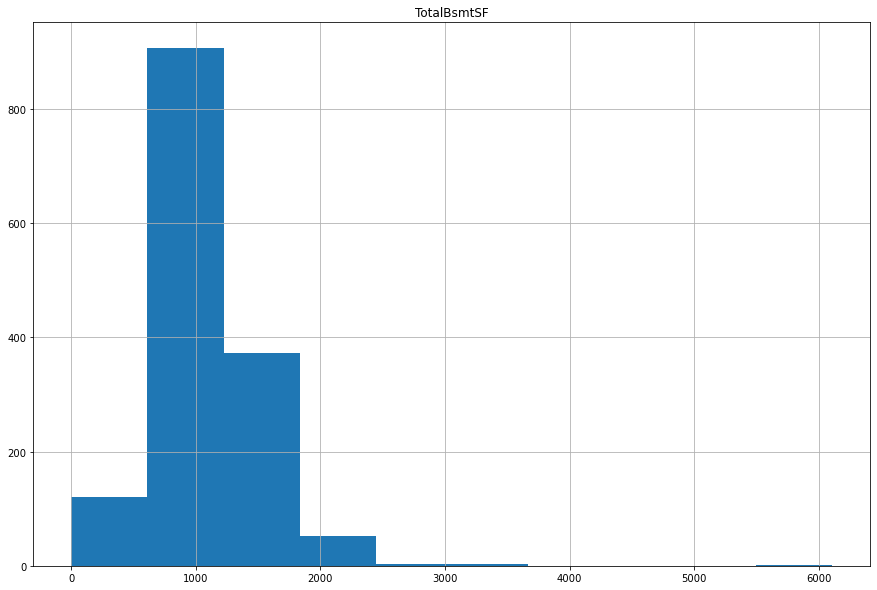

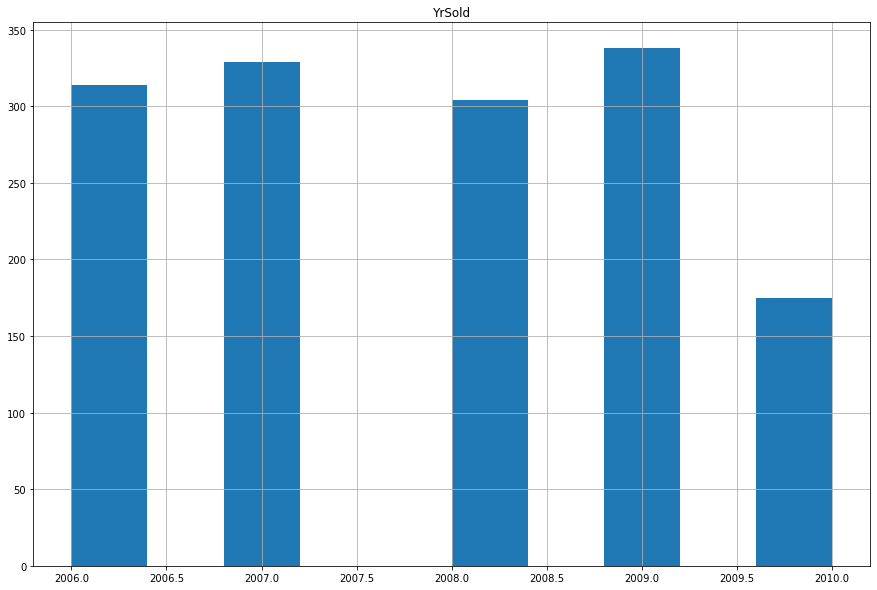

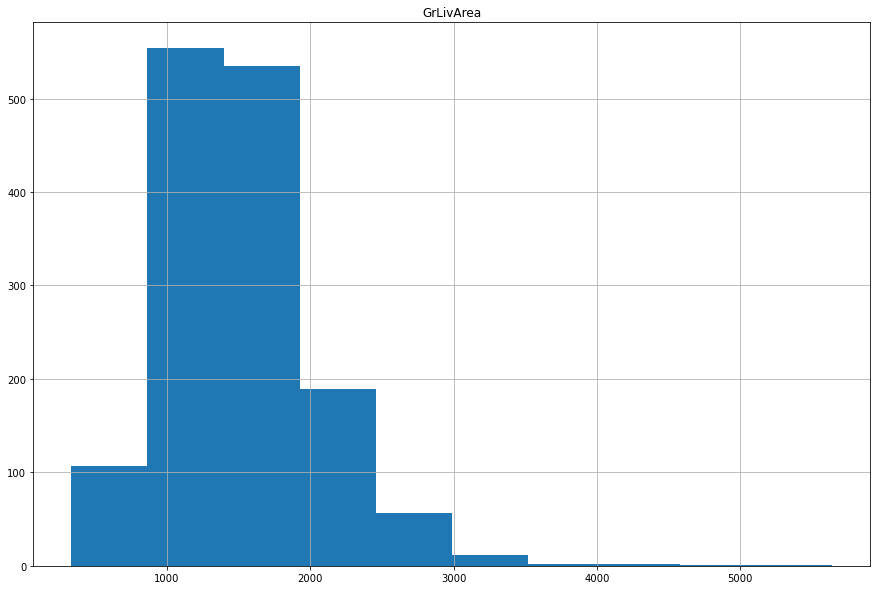

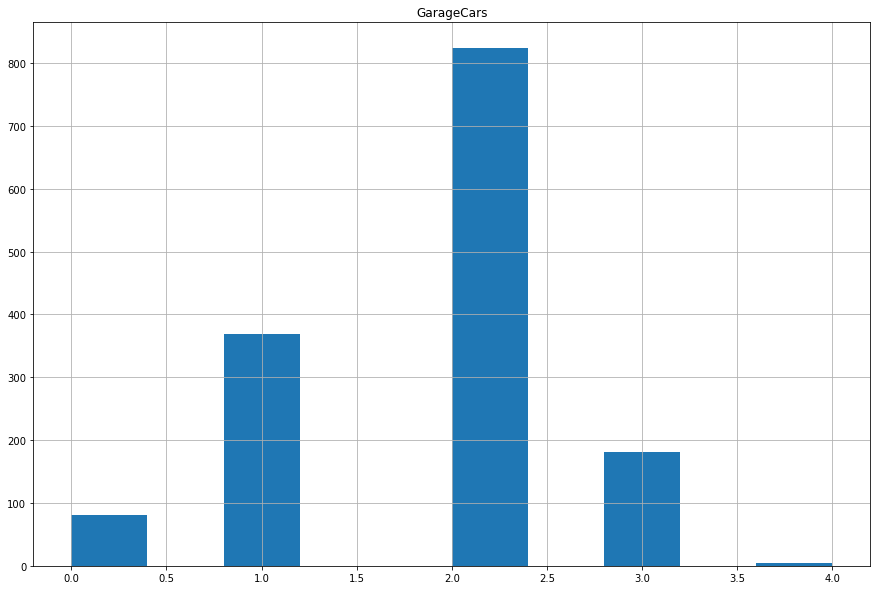

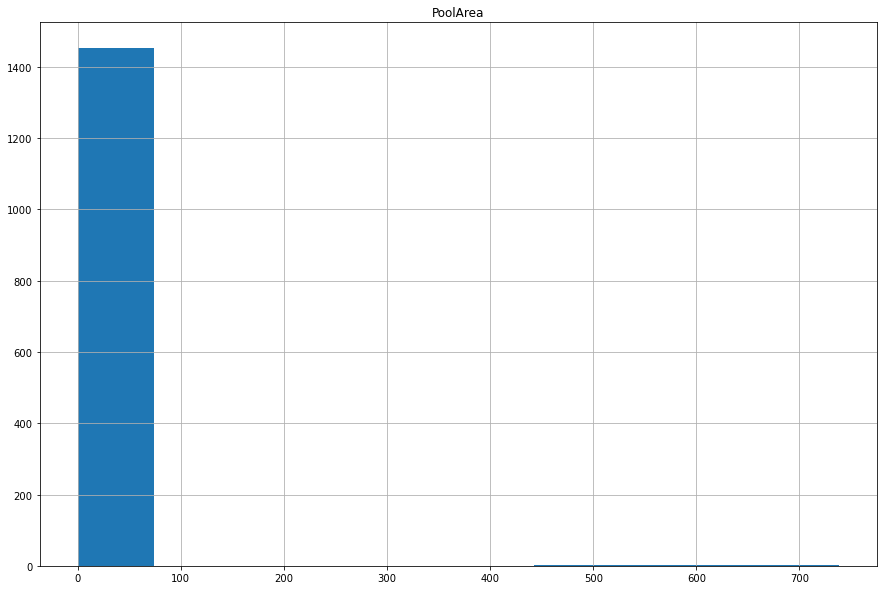

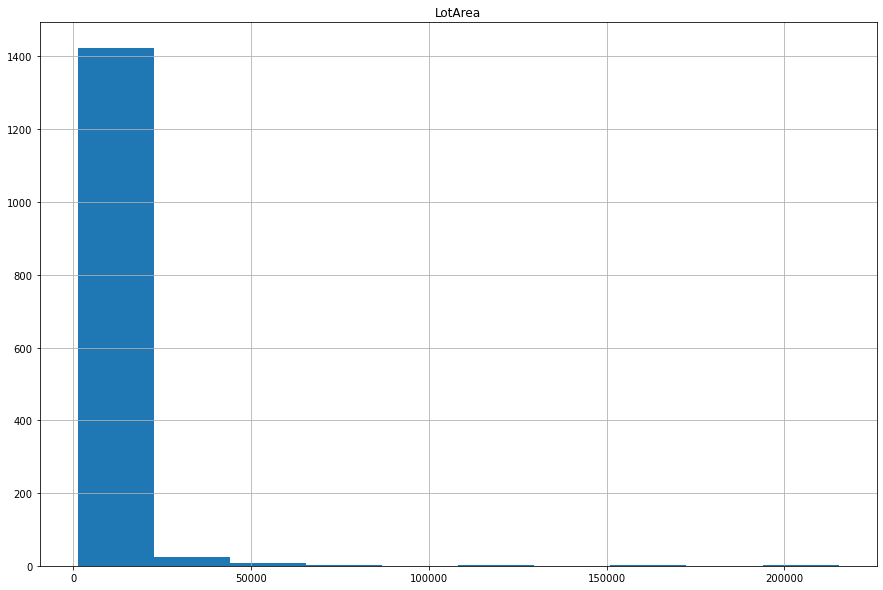

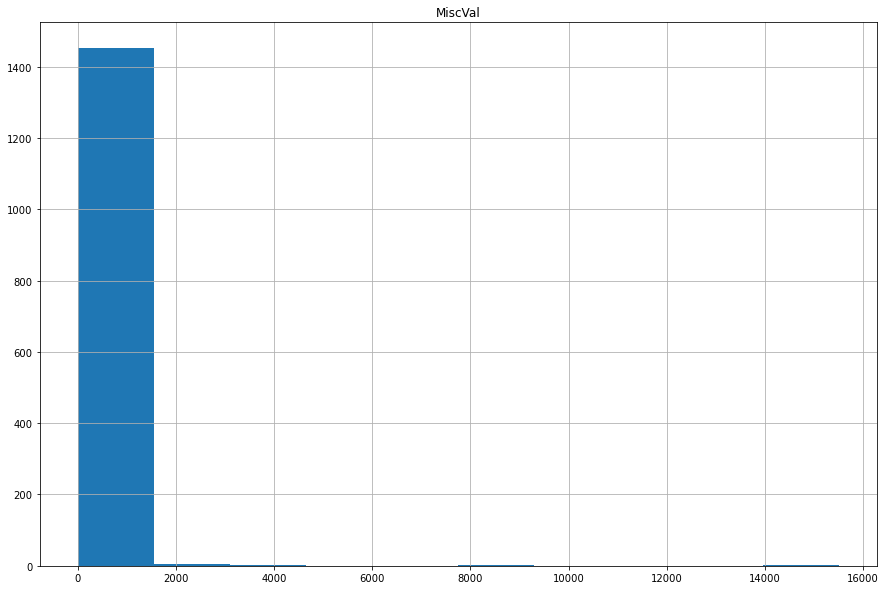

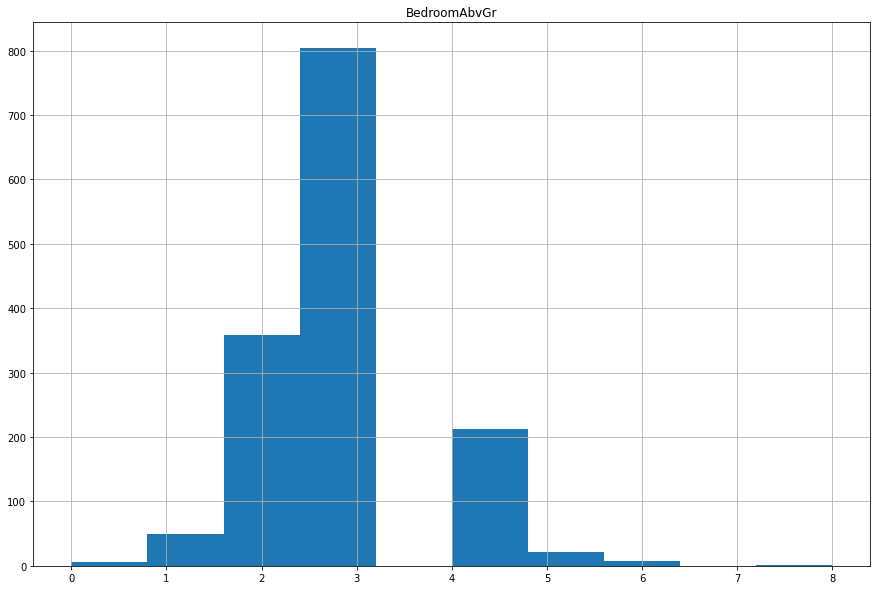

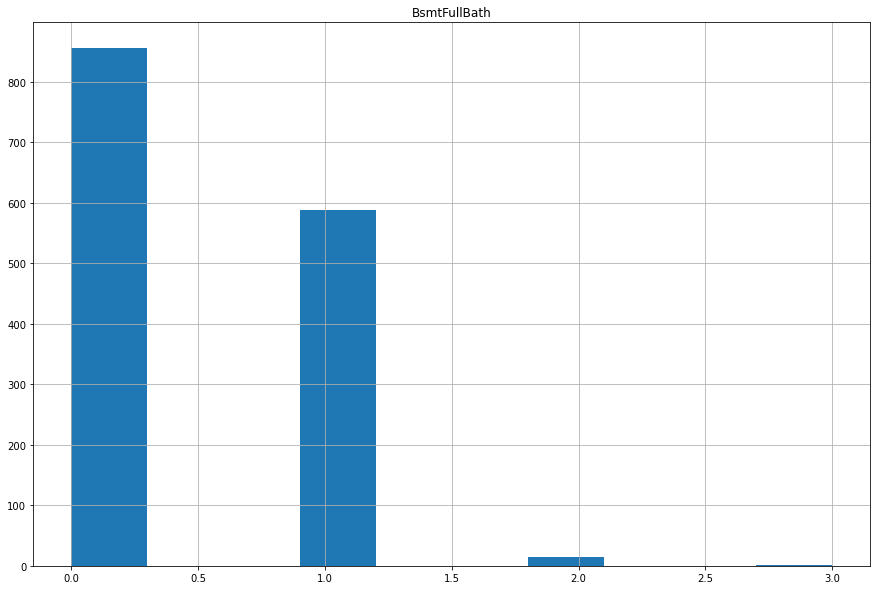

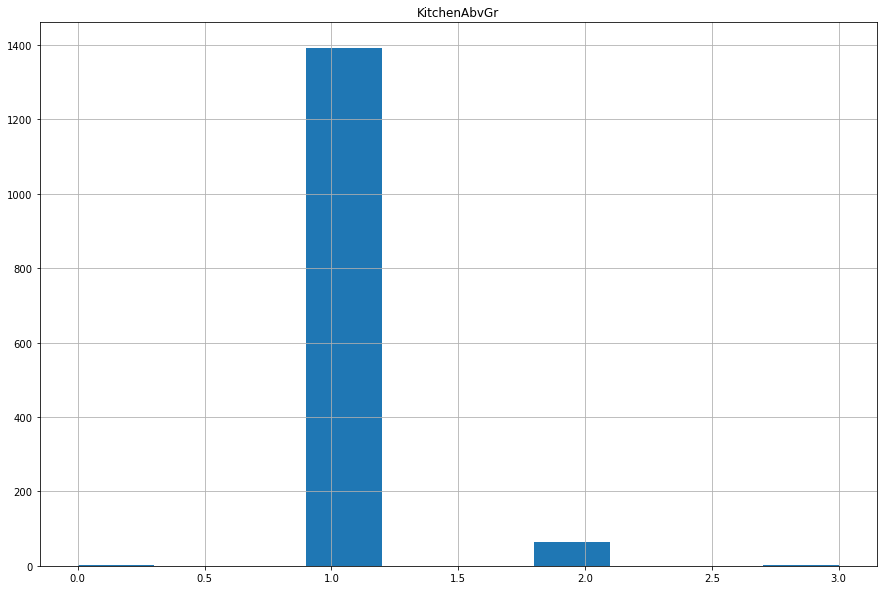

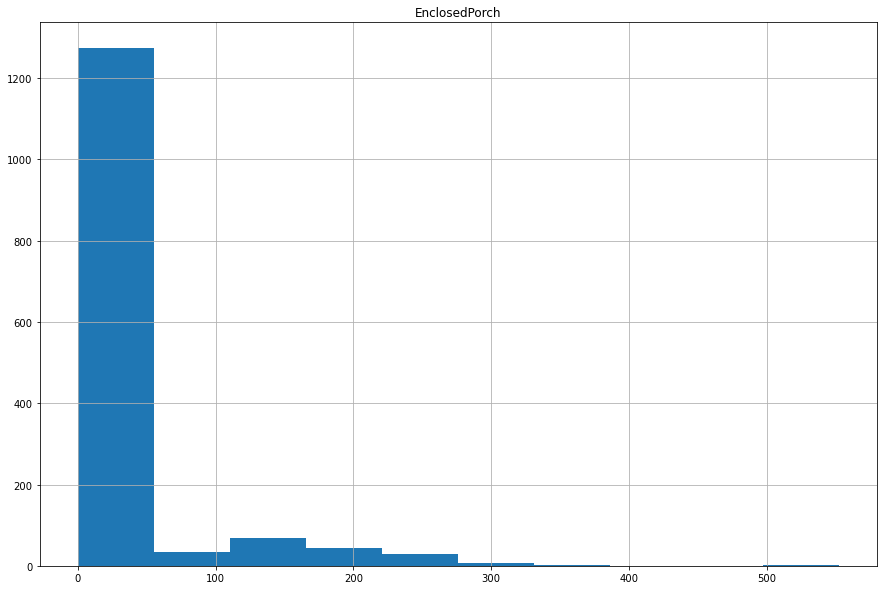

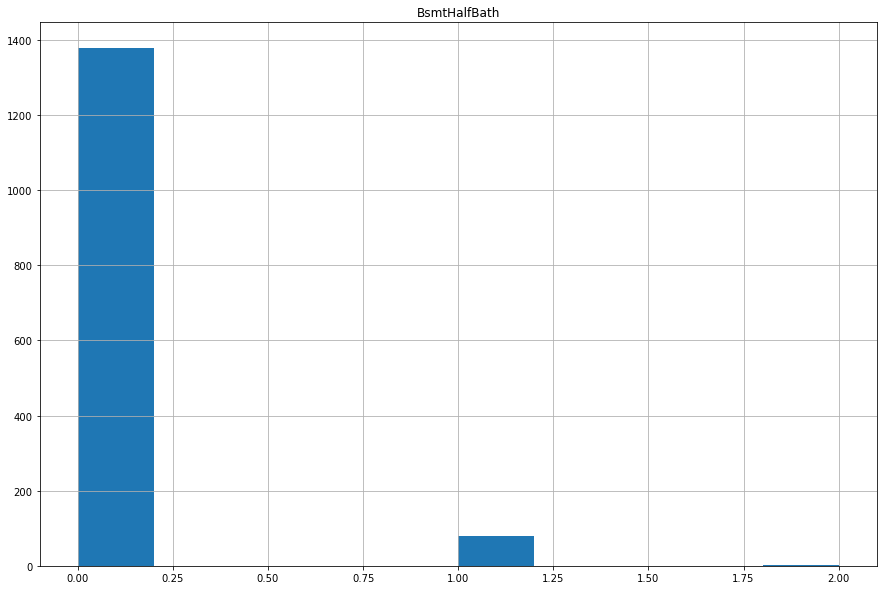

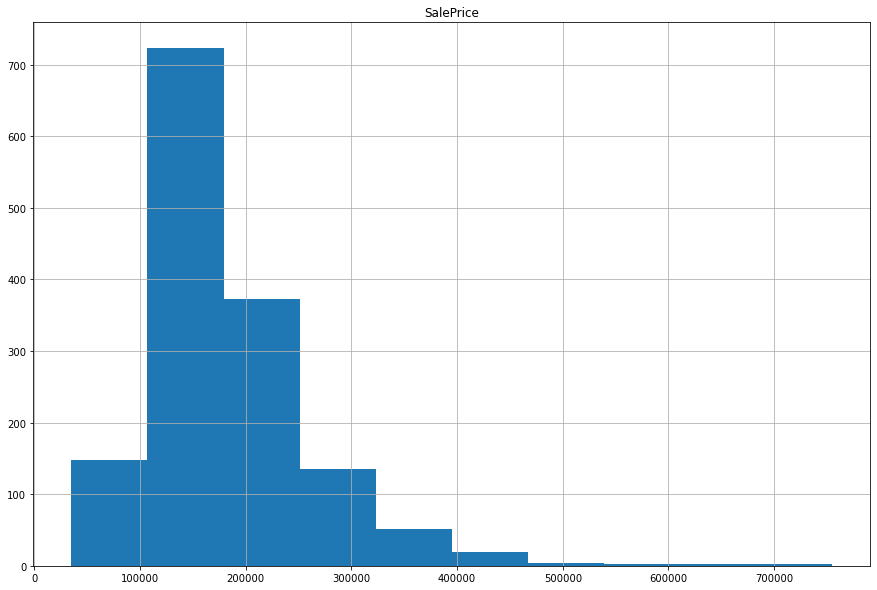

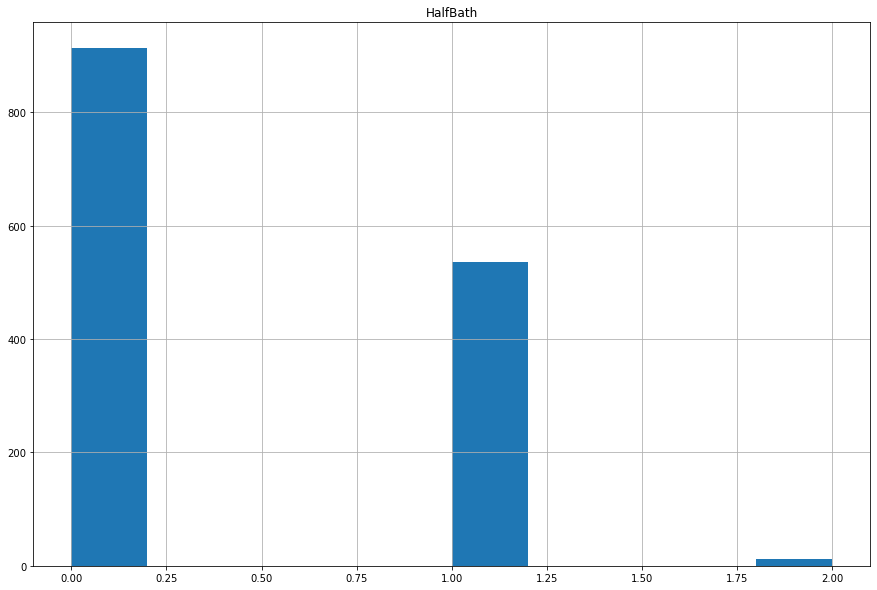

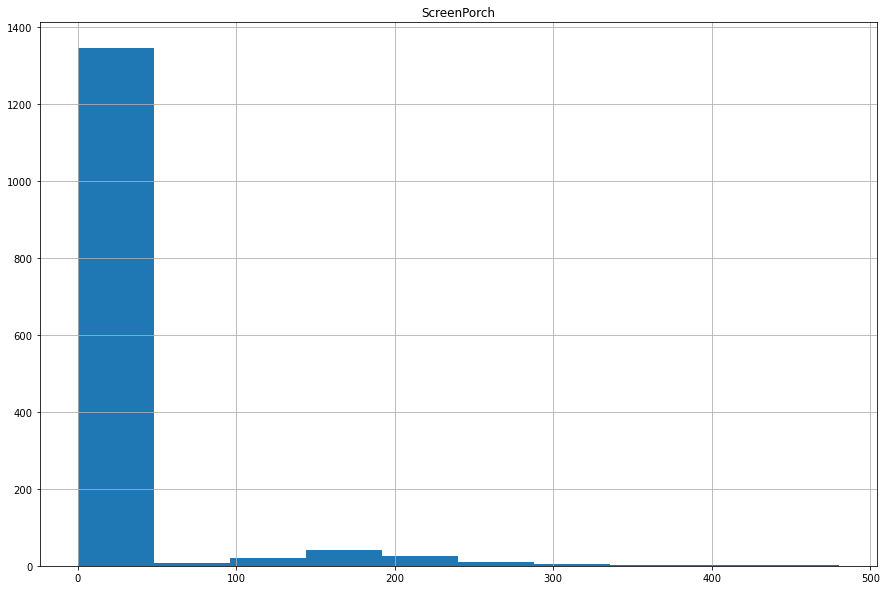

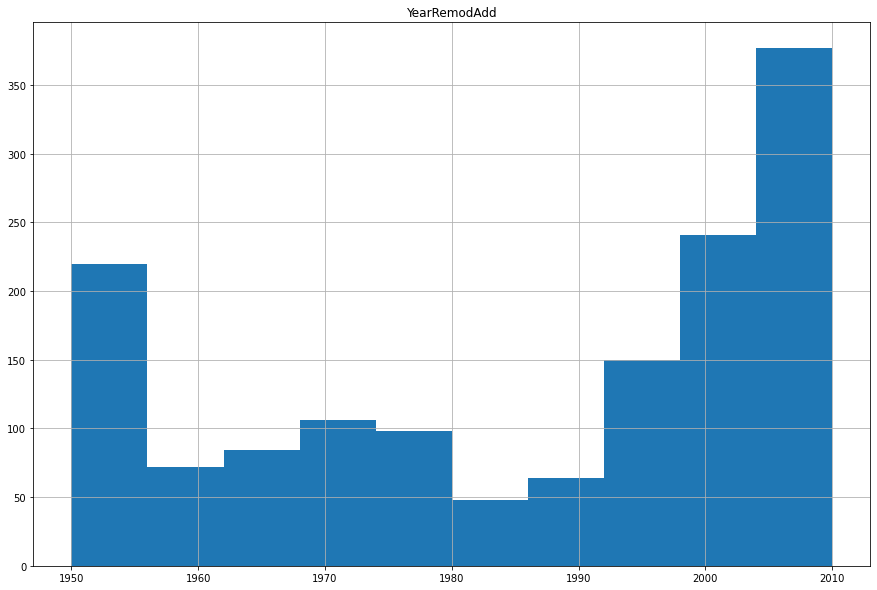

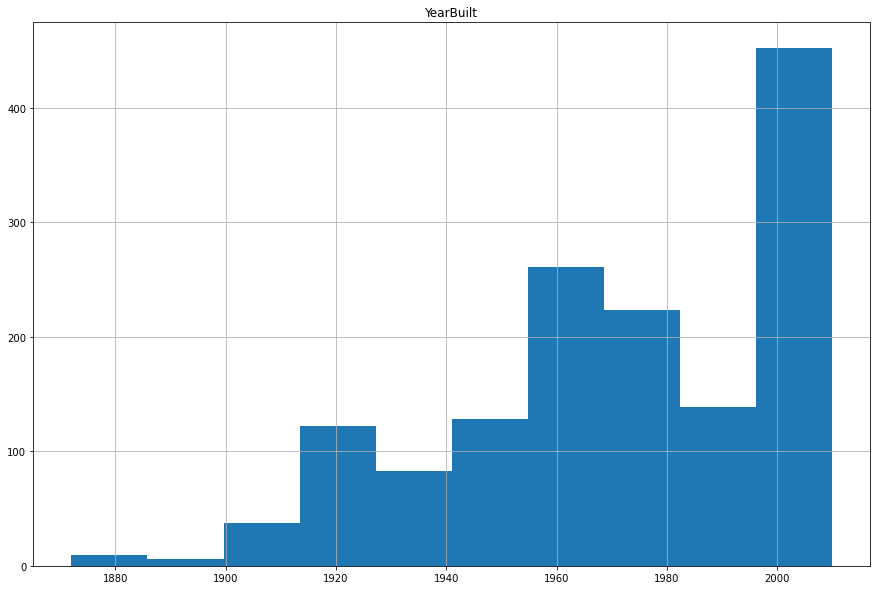

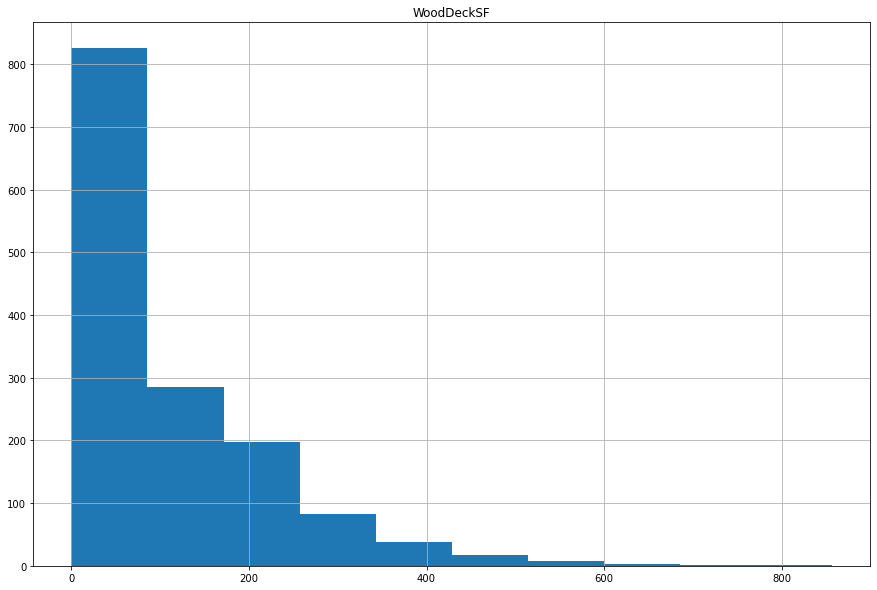

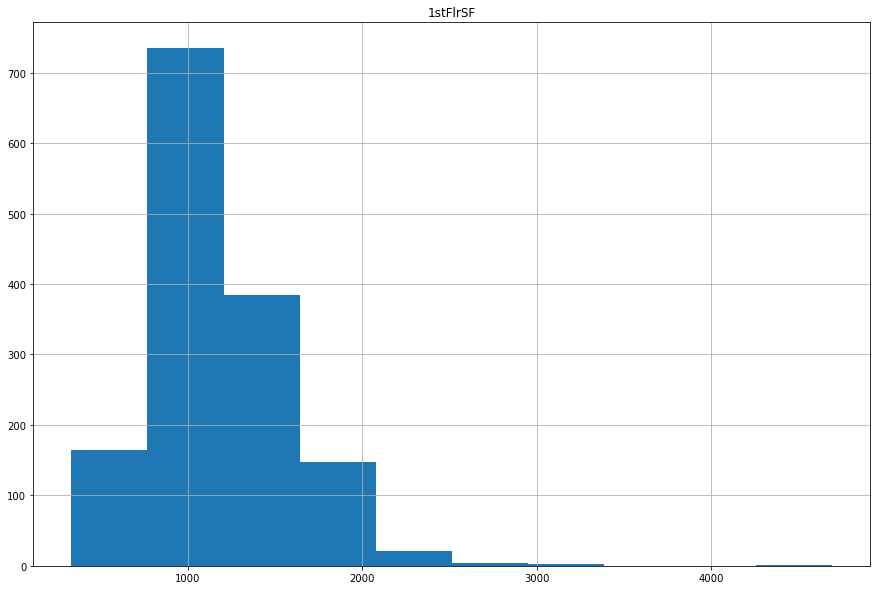

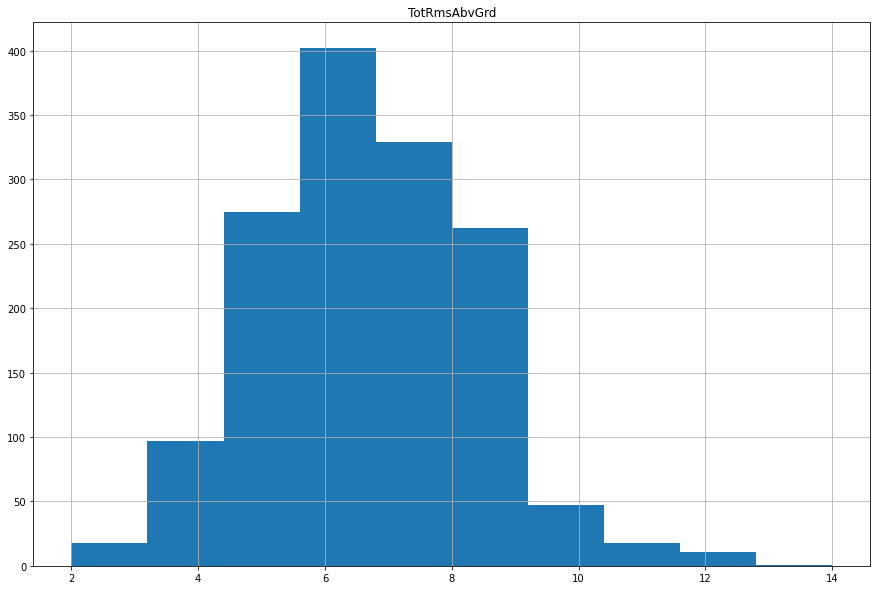

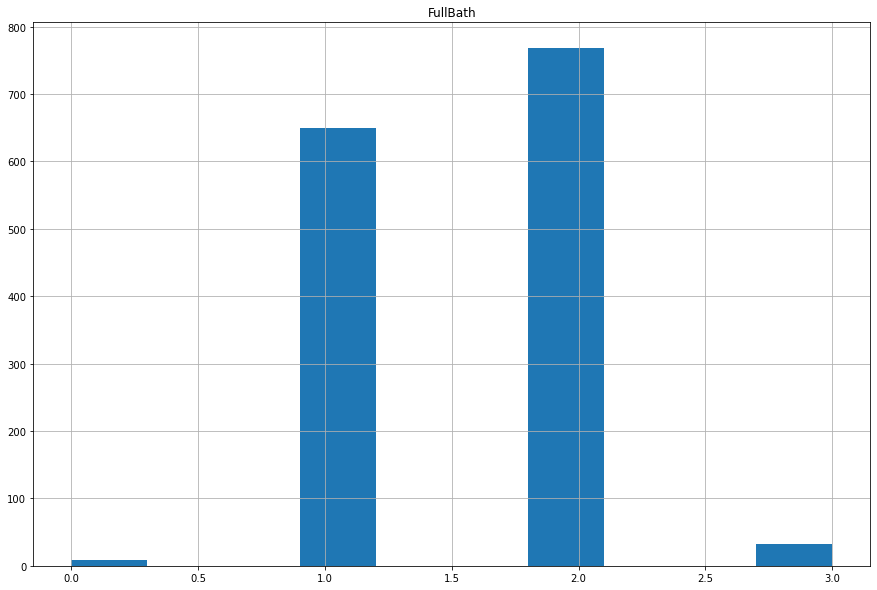

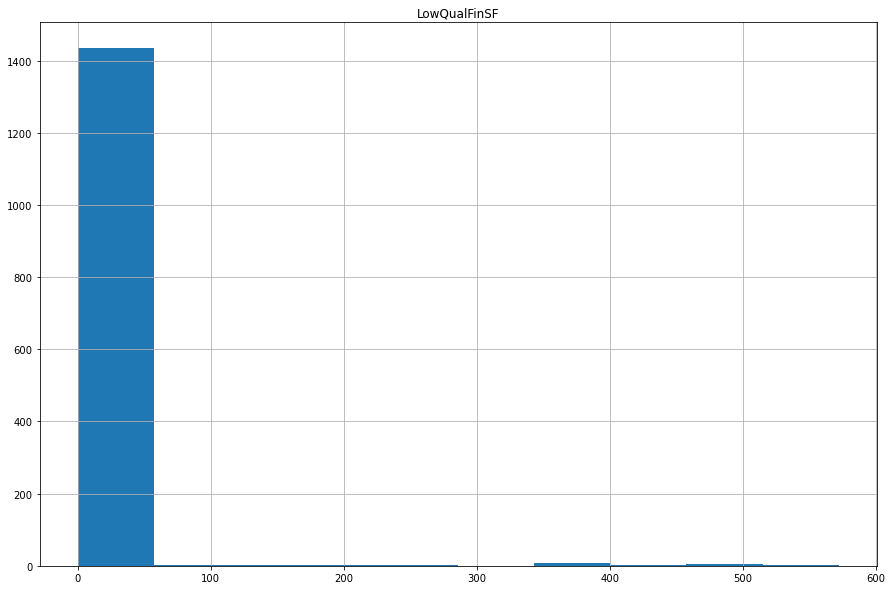

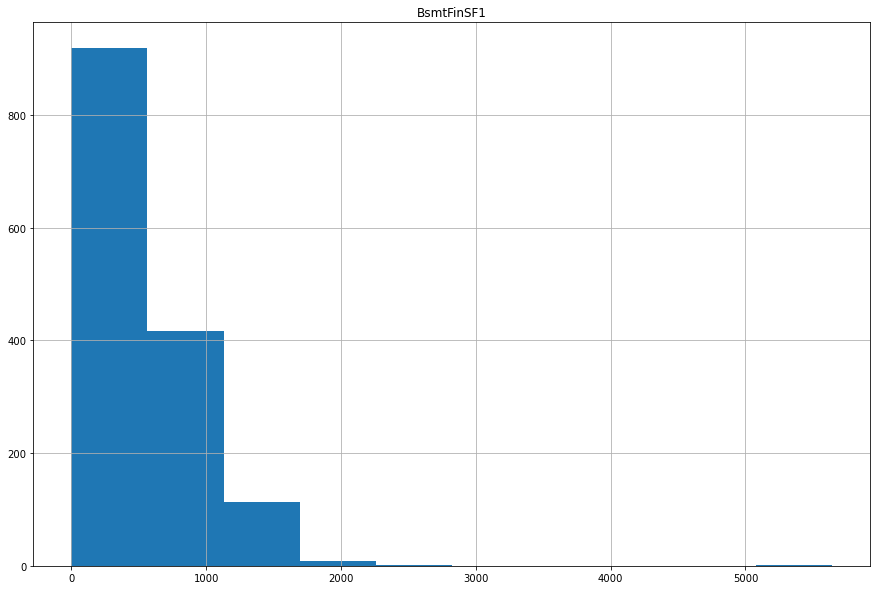

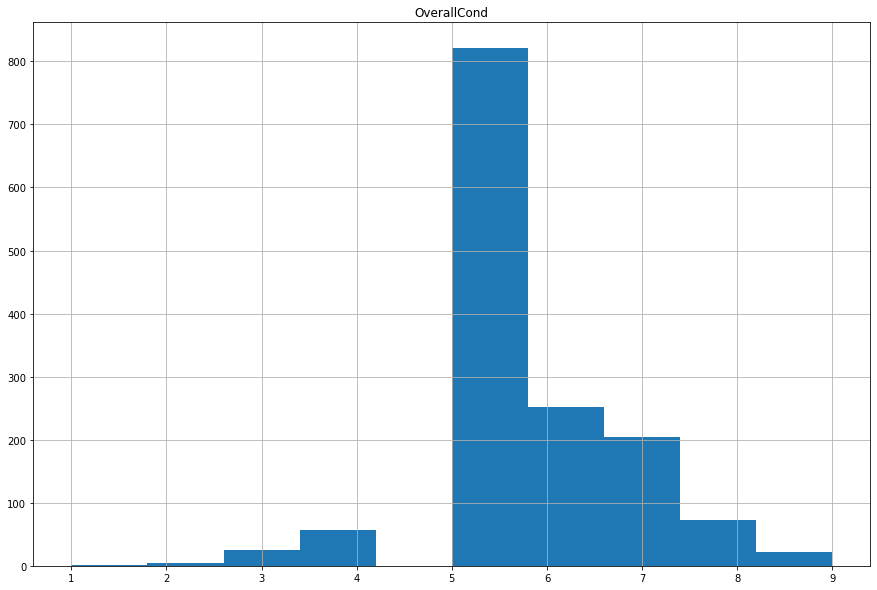

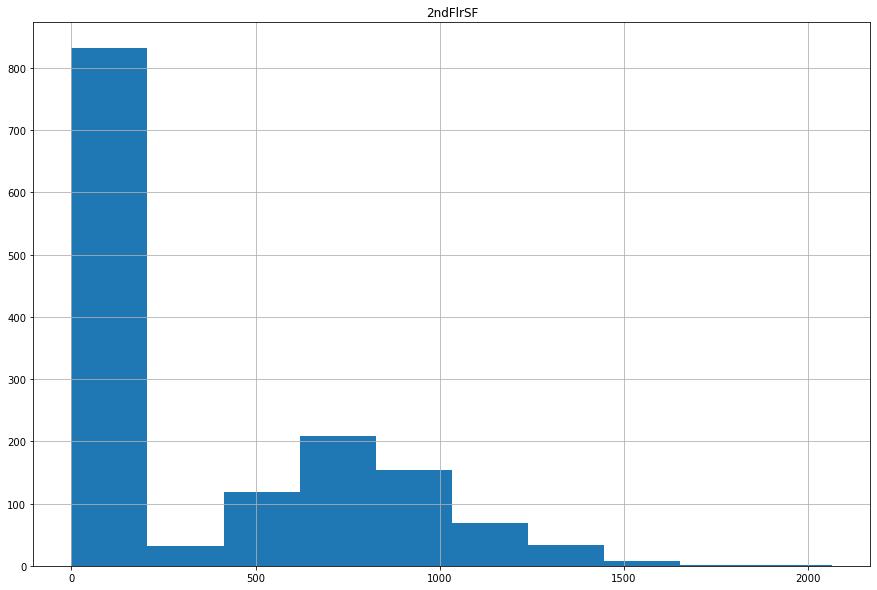

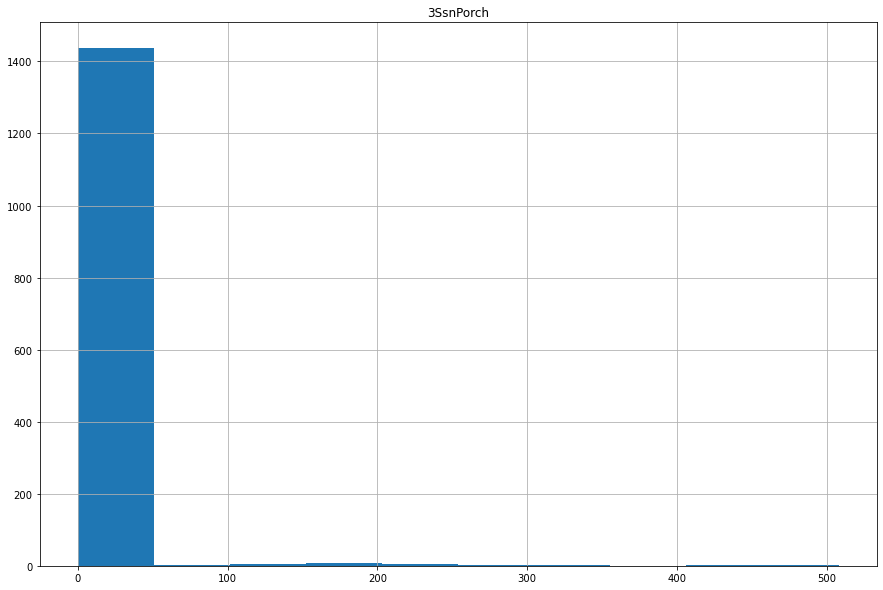

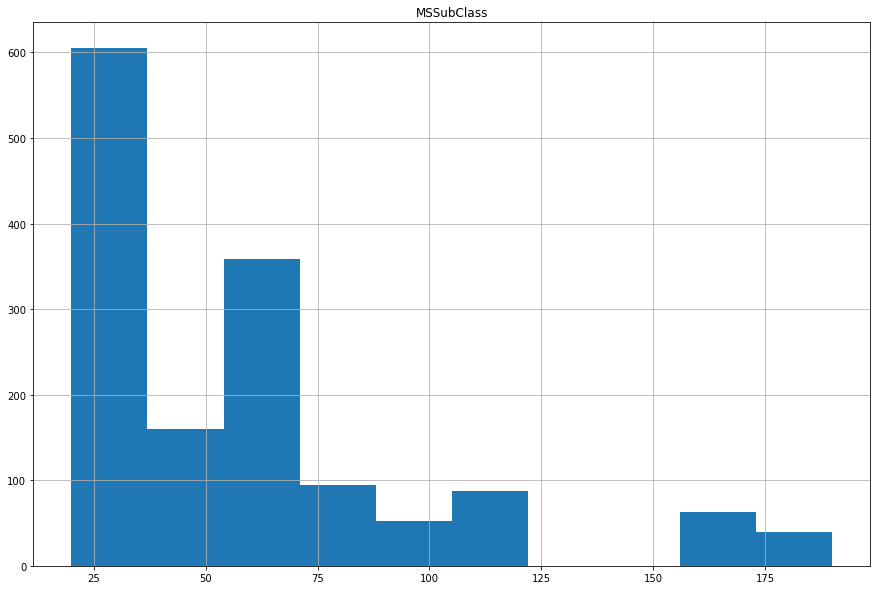

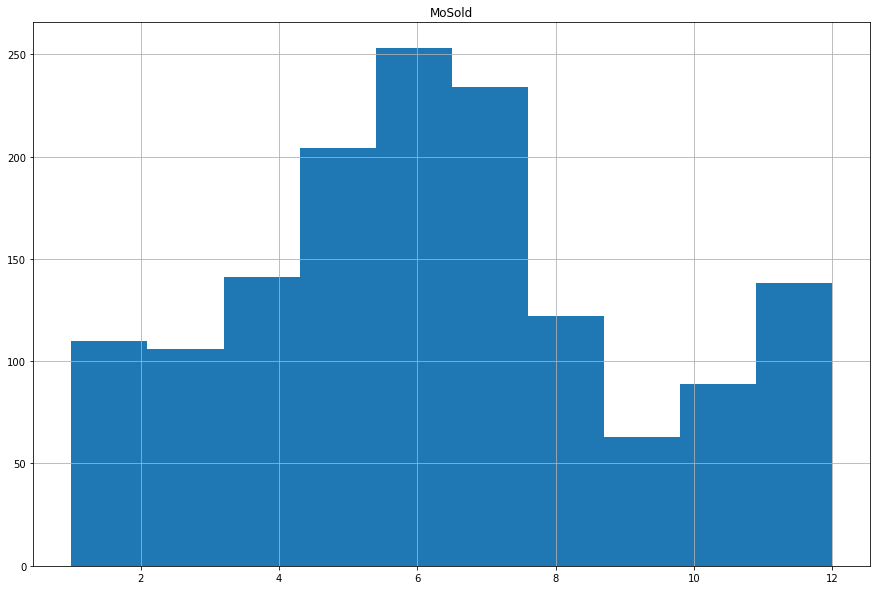

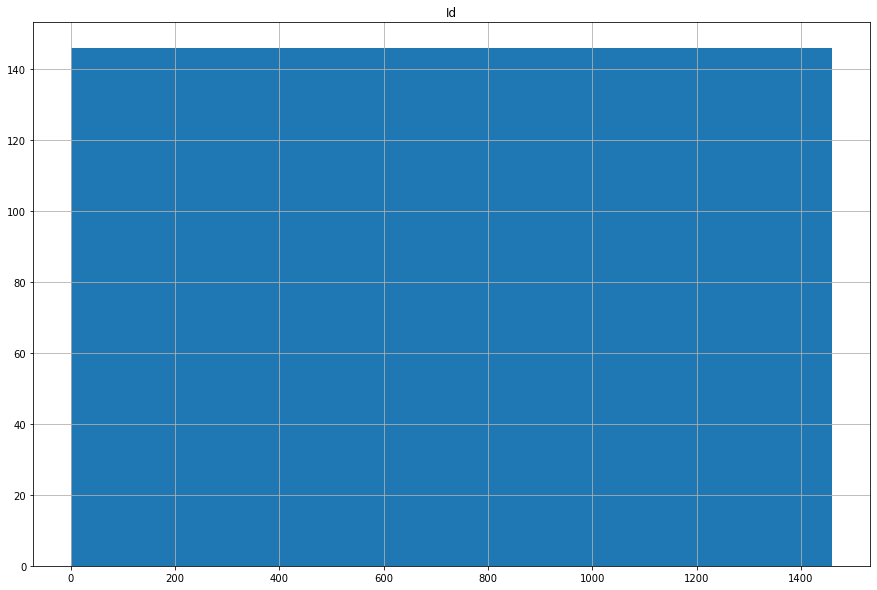

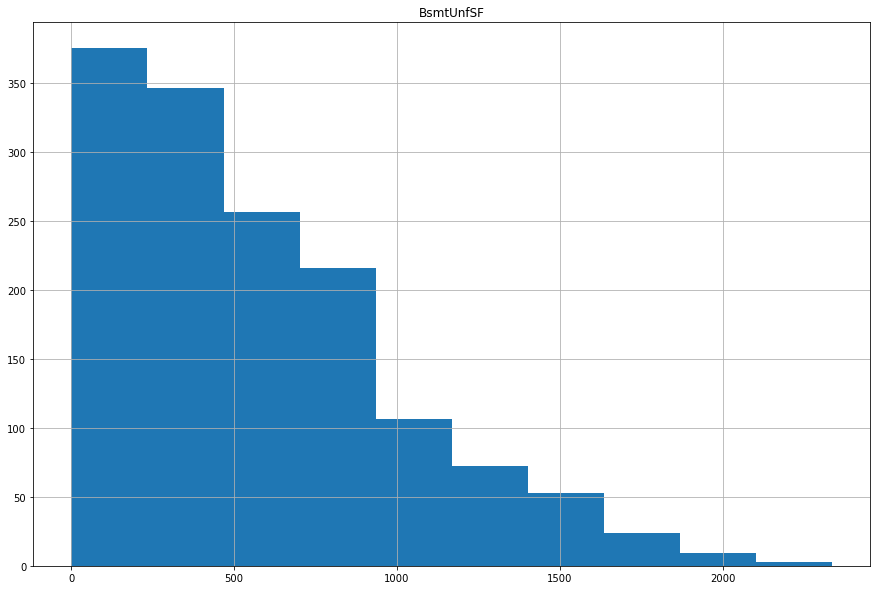

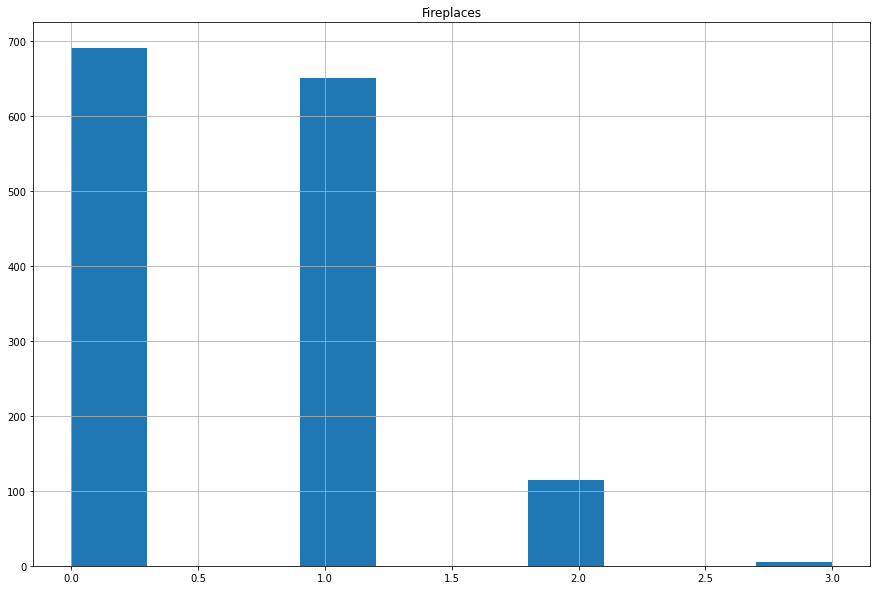

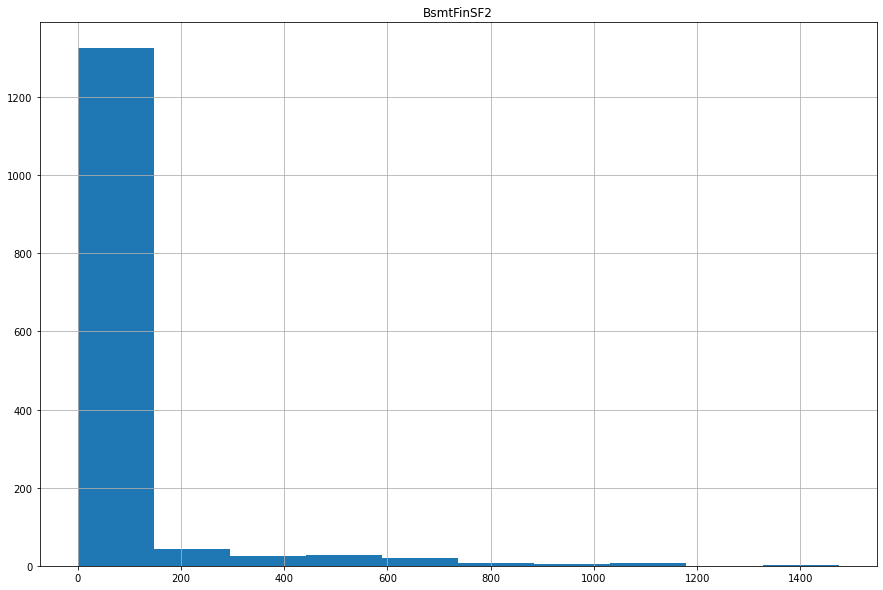

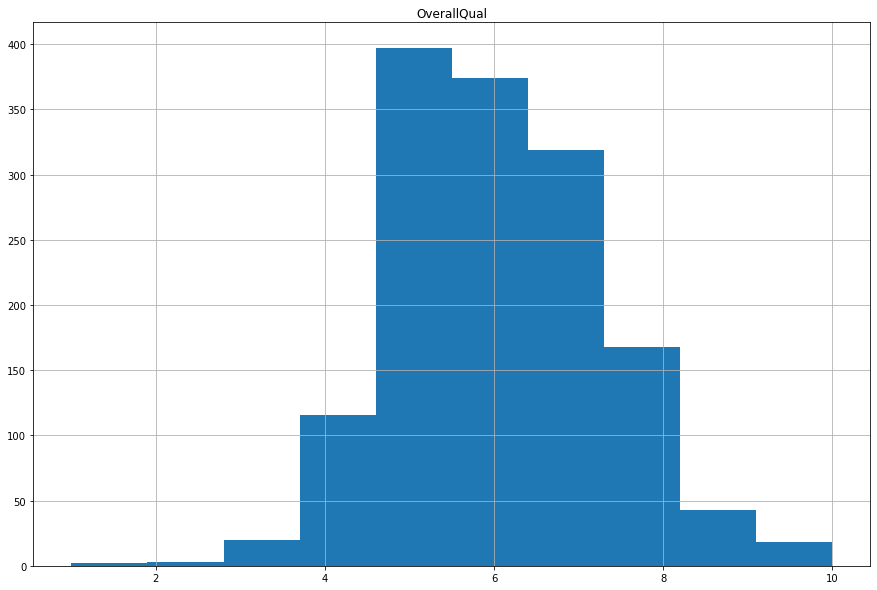

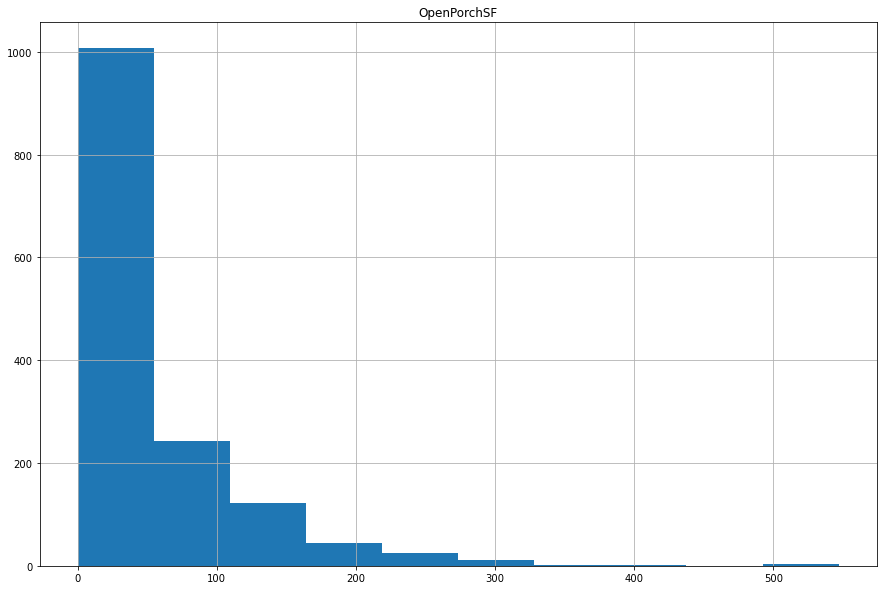

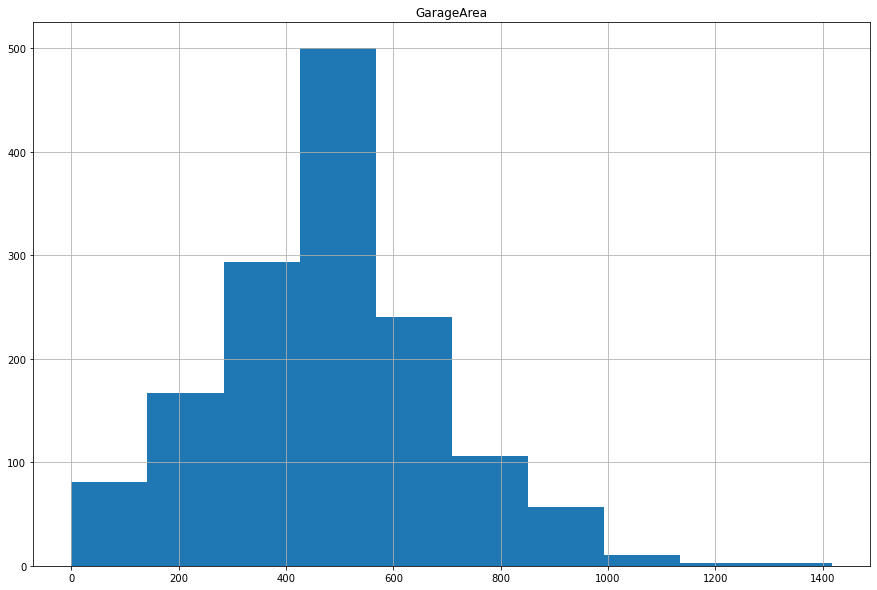

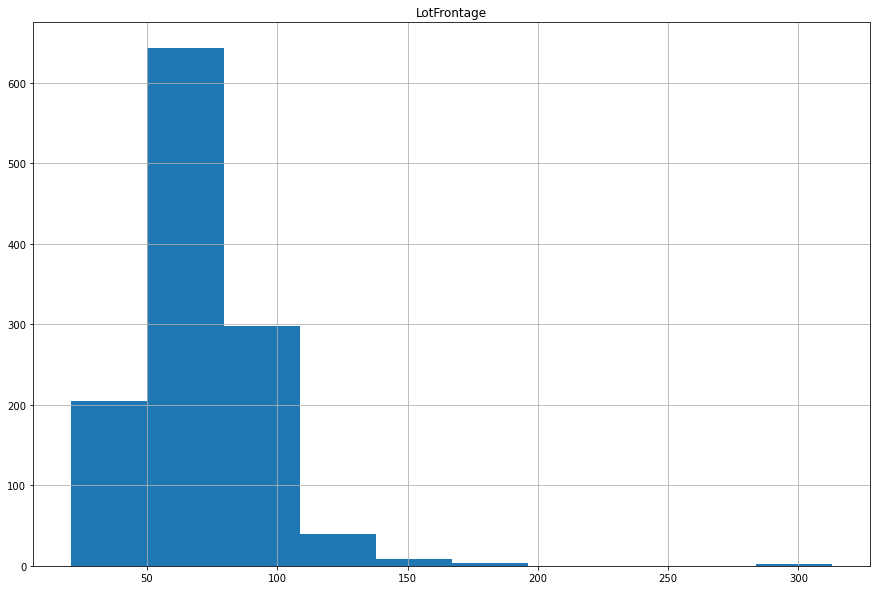

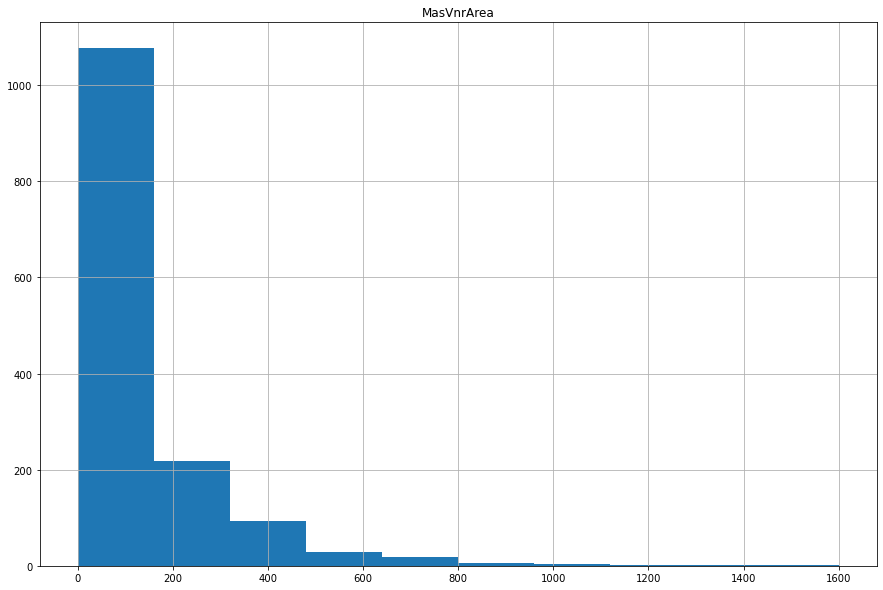

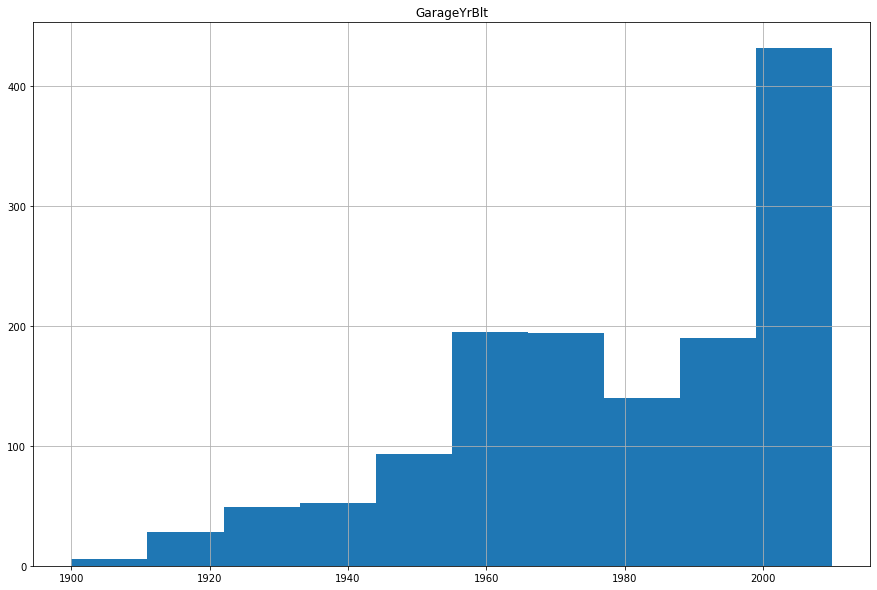

,count,mean,std,min,25%,50%,75%,max
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0
YrSold,1460.0,2007.815753,1.328095,2006.0,2007.00,2008.0,2009.00,2010.0
GrLivArea,1460.0,1515.463699,525.480383,334.0,1129.50,1464.0,1776.75,5642.0
GarageCars,1460.0,1.767123,0.747315,0.0,1.00,2.0,2.00,4.0
PoolArea,1460.0,2.758904,40.177307,0.0,0.00,0.0,0.00,738.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
MiscVal,1460.0,43.489041,496.123024,0.0,0.00,0.0,0.00,15500.0
BedroomAbvGr,1460.0,2.866438,0.815778,0.0,2.00,3.0,3.00,8.0
BsmtFullBath,1460.0,0.425342,0.518911,0.0,0.00,0.0,1.00,3.0
KitchenAbvGr,1460.0,1.046575,0.220338,0.0,1.00,1.0,1.00,3.0


In [21]:
describe_numerical_columns(df.select(num_cols), plot=1)

It would say that most of the numerical values have not got normal distribution. Also checking outliers is the necessary.
#### Categorical Columns

2023-04-18 06:23:05,515 - _utils.logging_utils - DEBUG - describe_categoric_columns function is executing...
2023-04-18 06:23:05,517 - _utils.logging_utils - INFO - ['MSZoning']
2023-04-18 06:23:05,609 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:05,612 - _utils.logging_utils - INFO - 
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


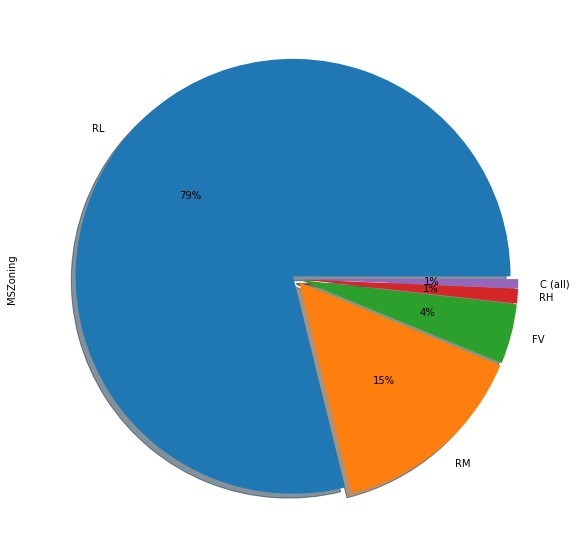

2023-04-18 06:23:05,754 - _utils.logging_utils - INFO - ['Street']
2023-04-18 06:23:05,834 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:05,835 - _utils.logging_utils - INFO - 
Pave    1454
Grvl       6
Name: Street, dtype: int64


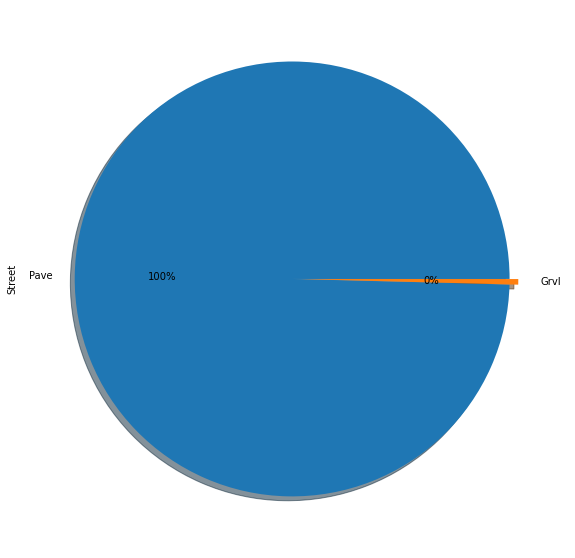

2023-04-18 06:23:05,941 - _utils.logging_utils - INFO - ['Alley']
2023-04-18 06:23:06,018 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:06,019 - _utils.logging_utils - INFO - 
NA      1369
Grvl      50
Pave      41
Name: Alley, dtype: int64


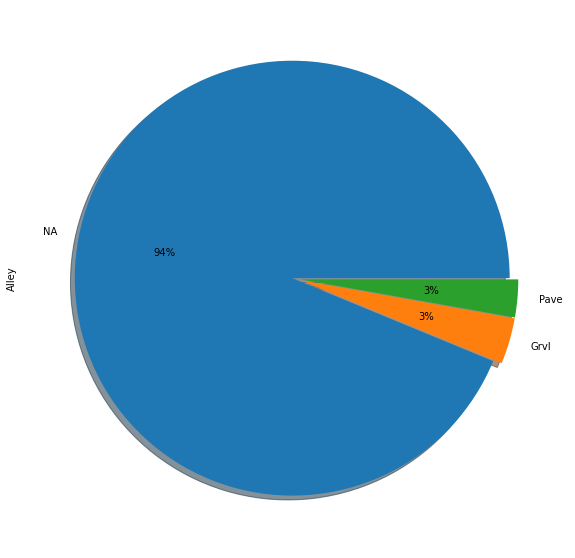

2023-04-18 06:23:06,143 - _utils.logging_utils - INFO - ['LotShape']
2023-04-18 06:23:06,232 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:06,234 - _utils.logging_utils - INFO - 
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64


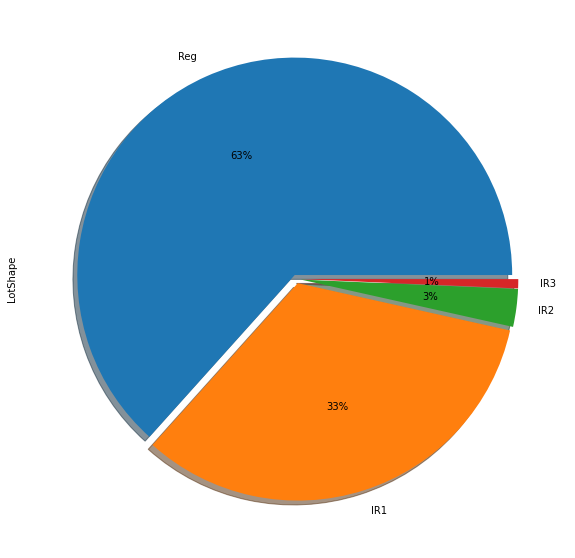

2023-04-18 06:23:06,360 - _utils.logging_utils - INFO - ['LandContour']
2023-04-18 06:23:06,445 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:06,446 - _utils.logging_utils - INFO - 
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


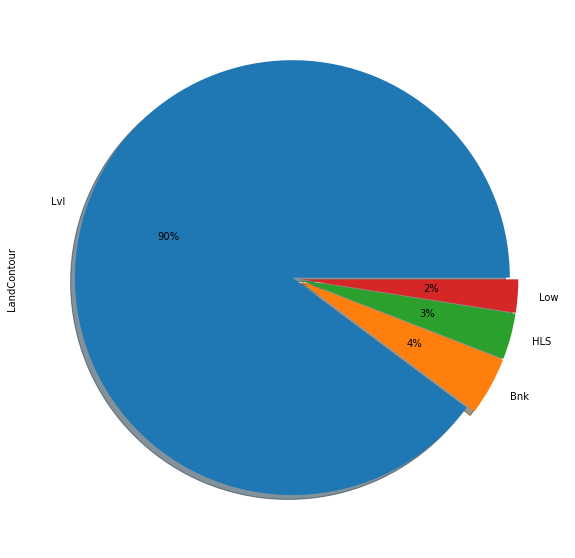

2023-04-18 06:23:06,592 - _utils.logging_utils - INFO - ['Utilities']
2023-04-18 06:23:06,664 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:06,666 - _utils.logging_utils - INFO - 
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


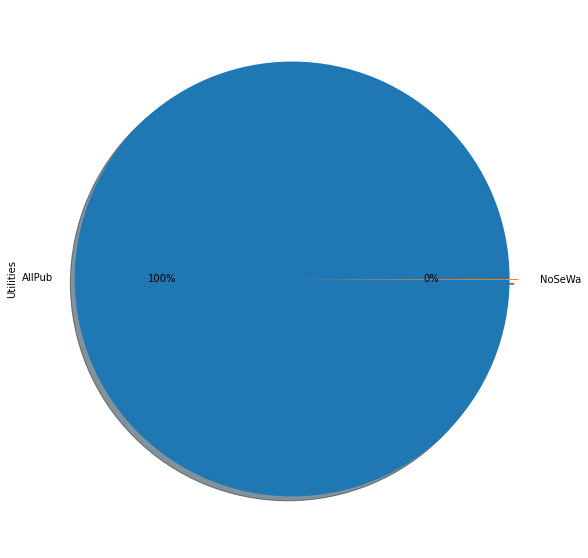

2023-04-18 06:23:06,796 - _utils.logging_utils - INFO - ['LotConfig']
2023-04-18 06:23:06,877 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:06,879 - _utils.logging_utils - INFO - 
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64


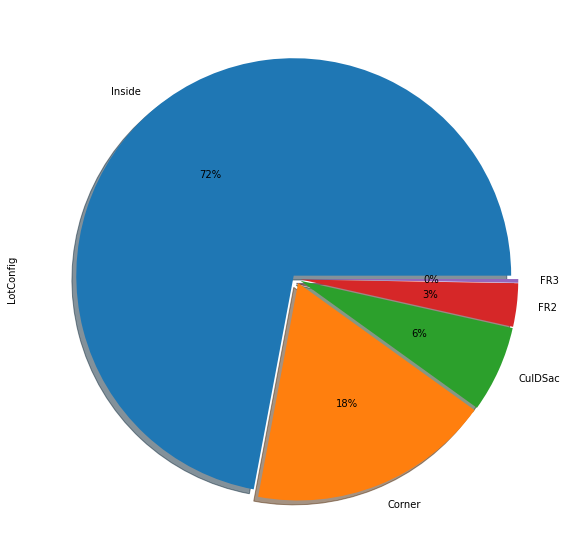

2023-04-18 06:23:07,015 - _utils.logging_utils - INFO - ['LandSlope']
2023-04-18 06:23:07,086 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:07,088 - _utils.logging_utils - INFO - 
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64


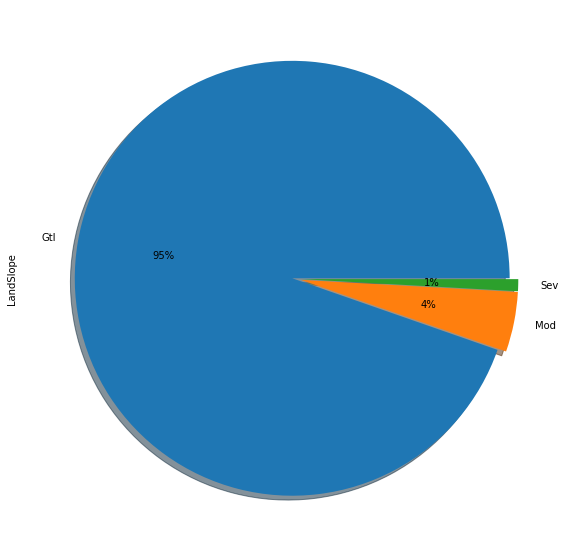

2023-04-18 06:23:07,211 - _utils.logging_utils - INFO - ['Neighborhood']
2023-04-18 06:23:07,278 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:07,279 - _utils.logging_utils - INFO - 
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64


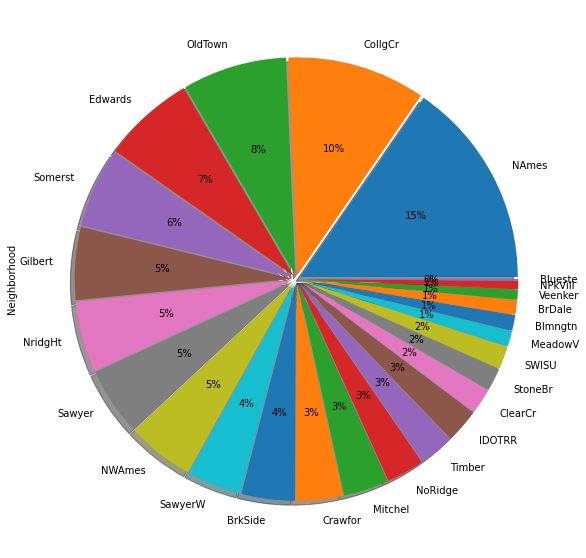

2023-04-18 06:23:07,615 - _utils.logging_utils - INFO - ['Condition1']
2023-04-18 06:23:07,687 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:07,689 - _utils.logging_utils - INFO - 
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64


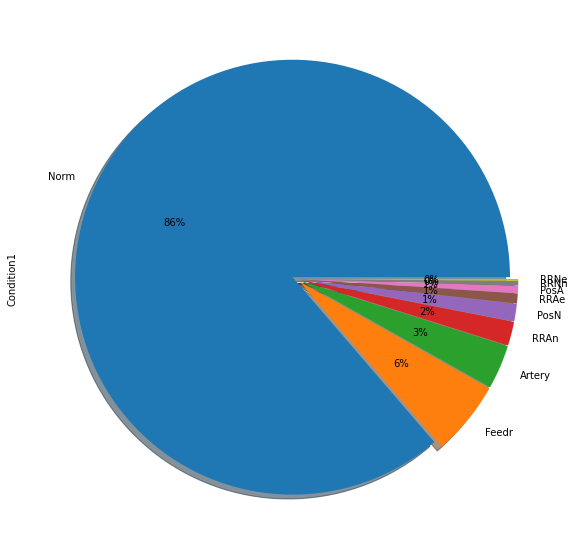

2023-04-18 06:23:07,869 - _utils.logging_utils - INFO - ['Condition2']
2023-04-18 06:23:07,959 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:07,962 - _utils.logging_utils - INFO - 
Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64


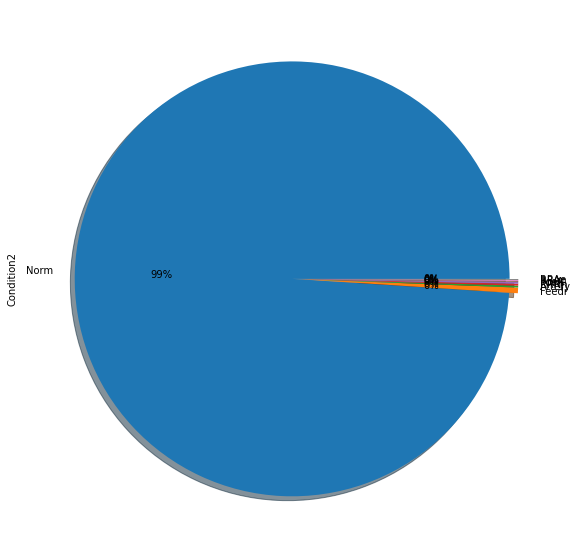

2023-04-18 06:23:08,126 - _utils.logging_utils - INFO - ['BldgType']
2023-04-18 06:23:08,195 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:08,197 - _utils.logging_utils - INFO - 
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64


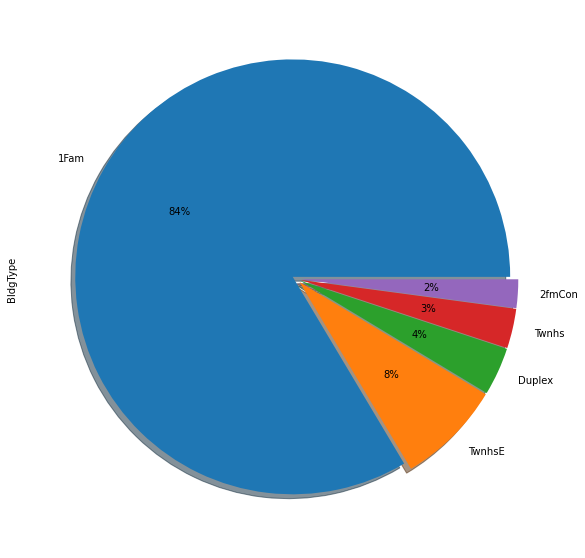

2023-04-18 06:23:08,416 - _utils.logging_utils - INFO - ['HouseStyle']
2023-04-18 06:23:08,479 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:08,481 - _utils.logging_utils - INFO - 
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64


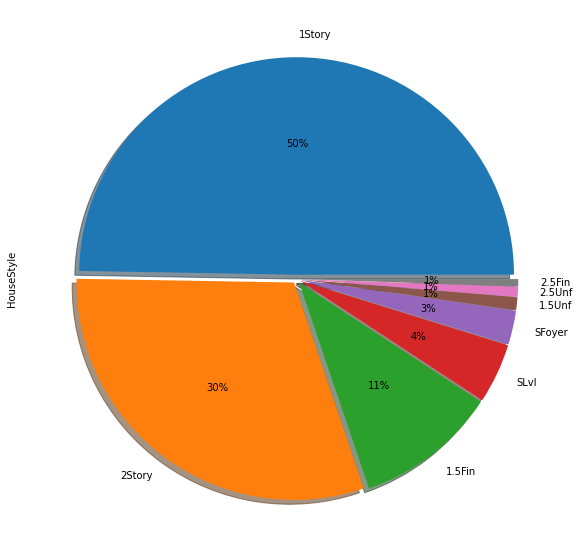

2023-04-18 06:23:08,625 - _utils.logging_utils - INFO - ['RoofStyle']
2023-04-18 06:23:08,686 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:08,688 - _utils.logging_utils - INFO - 
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64


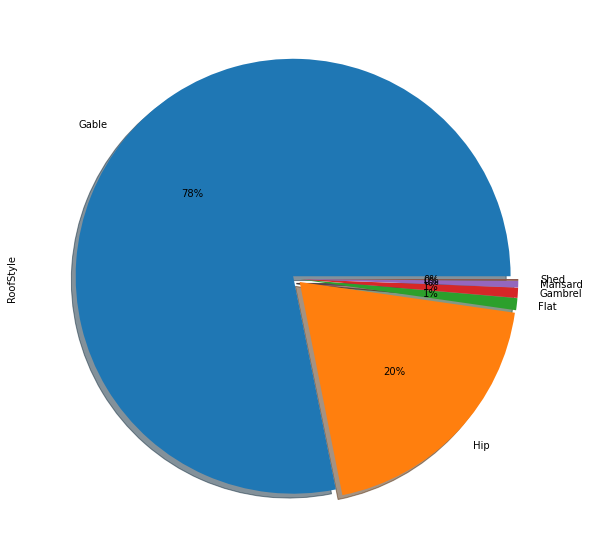

2023-04-18 06:23:08,825 - _utils.logging_utils - INFO - ['RoofMatl']
2023-04-18 06:23:08,889 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:08,891 - _utils.logging_utils - INFO - 
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64


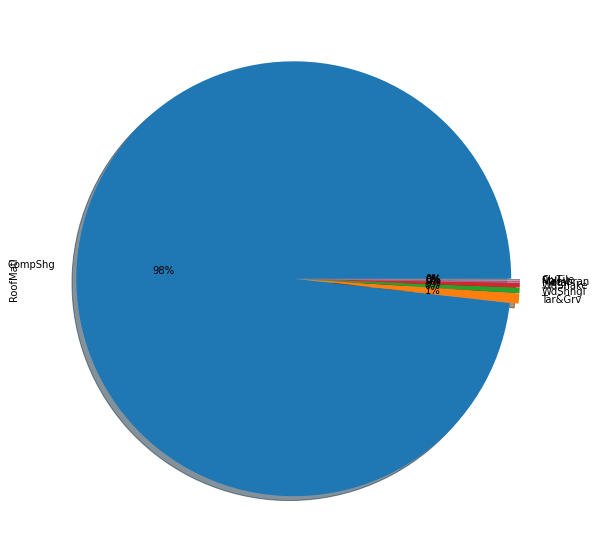

2023-04-18 06:23:09,084 - _utils.logging_utils - INFO - ['Exterior1st']
2023-04-18 06:23:09,167 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:09,169 - _utils.logging_utils - INFO - 
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64


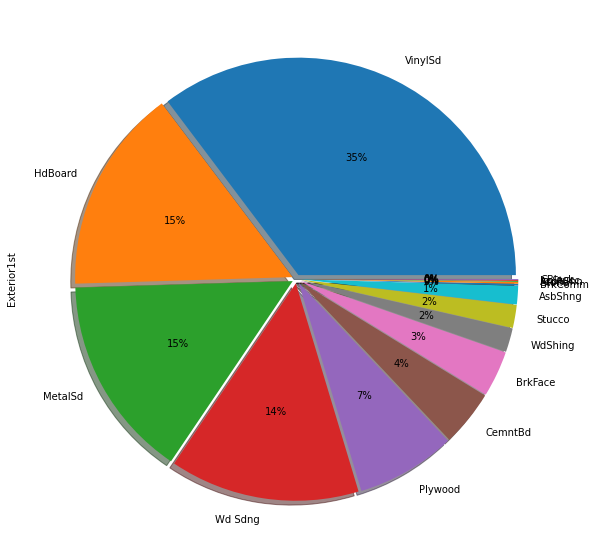

2023-04-18 06:23:09,388 - _utils.logging_utils - INFO - ['Exterior2nd']
2023-04-18 06:23:09,467 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:09,468 - _utils.logging_utils - INFO - 
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64


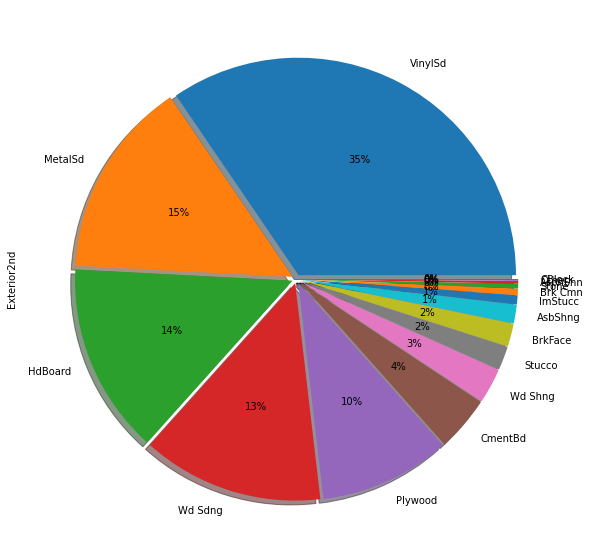

2023-04-18 06:23:09,701 - _utils.logging_utils - INFO - ['MasVnrType']
2023-04-18 06:23:09,766 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:09,767 - _utils.logging_utils - INFO - 
None       864
BrkFace    445
Stone      128
BrkCmn      15
NA           8
Name: MasVnrType, dtype: int64


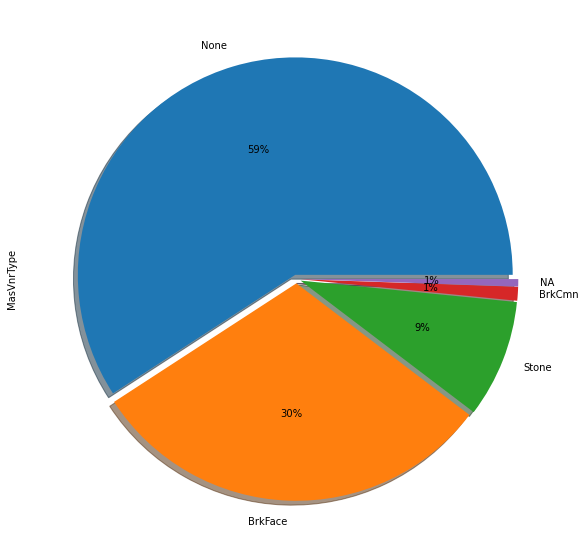

2023-04-18 06:23:09,885 - _utils.logging_utils - INFO - ['ExterQual']
2023-04-18 06:23:09,947 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:09,948 - _utils.logging_utils - INFO - 
TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64


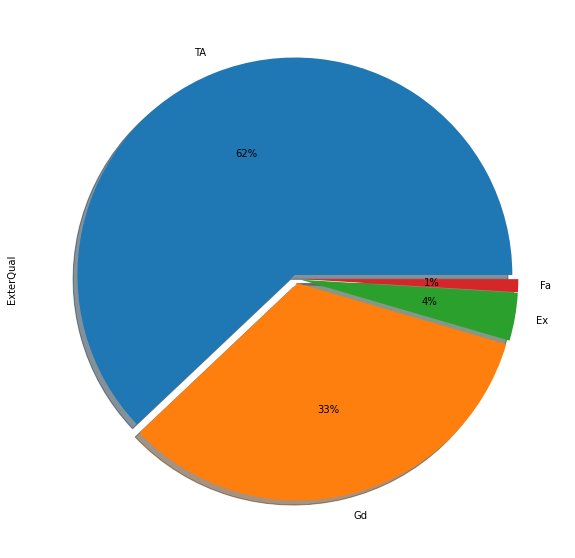

2023-04-18 06:23:10,065 - _utils.logging_utils - INFO - ['ExterCond']
2023-04-18 06:23:10,135 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:10,137 - _utils.logging_utils - INFO - 
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64


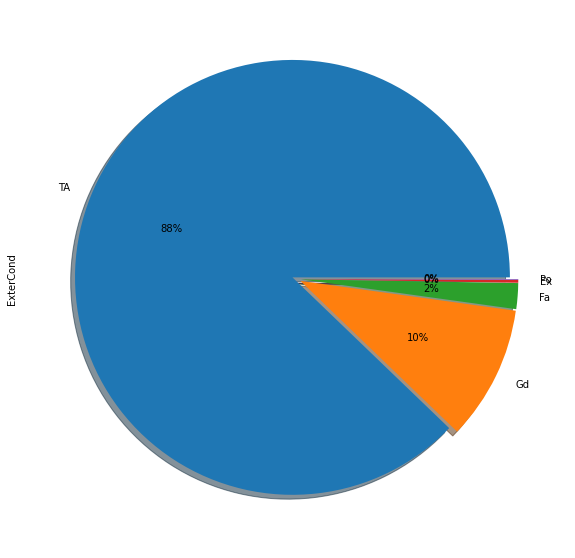

2023-04-18 06:23:10,285 - _utils.logging_utils - INFO - ['Foundation']
2023-04-18 06:23:10,375 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:10,377 - _utils.logging_utils - INFO - 
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64


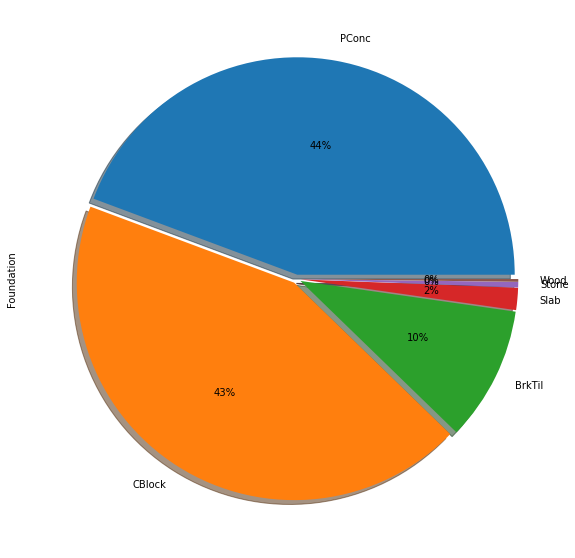

2023-04-18 06:23:10,501 - _utils.logging_utils - INFO - ['BsmtQual']
2023-04-18 06:23:10,569 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:10,572 - _utils.logging_utils - INFO - 
TA    649
Gd    618
Ex    121
NA     37
Fa     35
Name: BsmtQual, dtype: int64


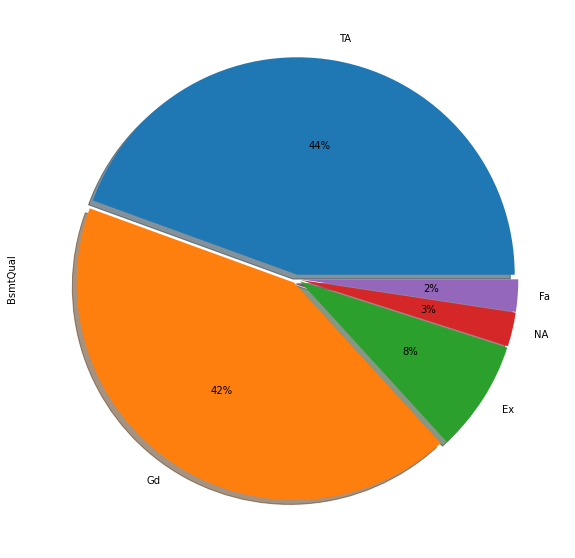

2023-04-18 06:23:10,689 - _utils.logging_utils - INFO - ['BsmtCond']
2023-04-18 06:23:10,764 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:10,766 - _utils.logging_utils - INFO - 
TA    1311
Gd      65
Fa      45
NA      37
Po       2
Name: BsmtCond, dtype: int64


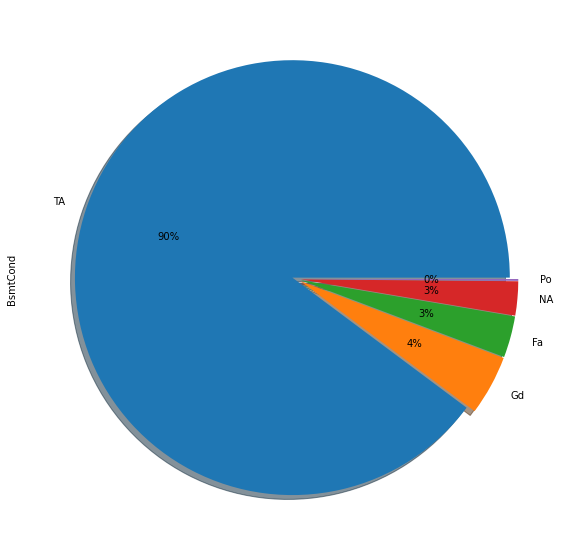

2023-04-18 06:23:10,912 - _utils.logging_utils - INFO - ['BsmtExposure']
2023-04-18 06:23:10,985 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:10,987 - _utils.logging_utils - INFO - 
No    953
Av    221
Gd    134
Mn    114
NA     38
Name: BsmtExposure, dtype: int64


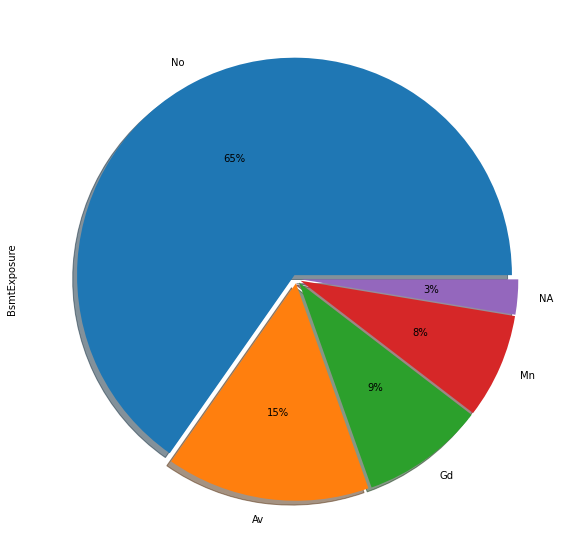

2023-04-18 06:23:11,108 - _utils.logging_utils - INFO - ['BsmtFinType1']
2023-04-18 06:23:11,190 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:11,191 - _utils.logging_utils - INFO - 
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NA      37
Name: BsmtFinType1, dtype: int64


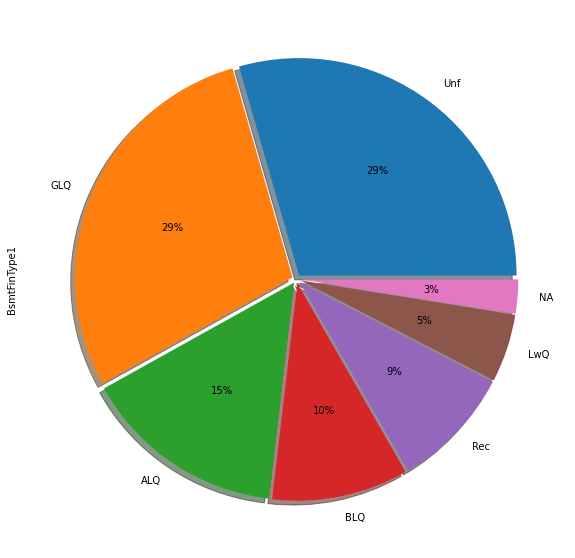

2023-04-18 06:23:11,331 - _utils.logging_utils - INFO - ['BsmtFinType2']
2023-04-18 06:23:11,390 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:11,392 - _utils.logging_utils - INFO - 
Unf    1256
Rec      54
LwQ      46
NA       38
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64


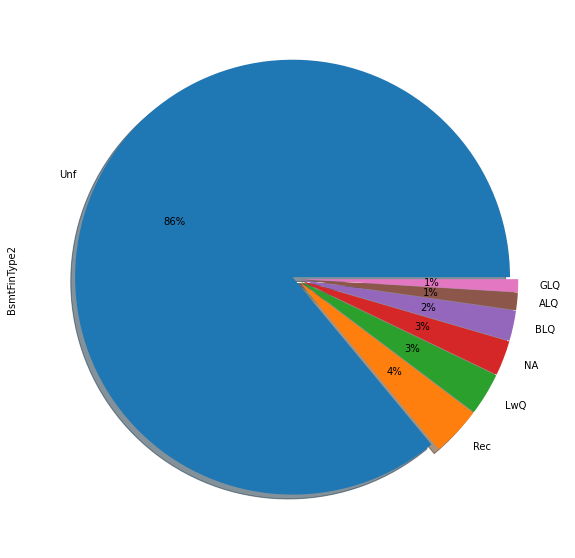

2023-04-18 06:23:11,552 - _utils.logging_utils - INFO - ['Heating']
2023-04-18 06:23:11,609 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:11,610 - _utils.logging_utils - INFO - 
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64


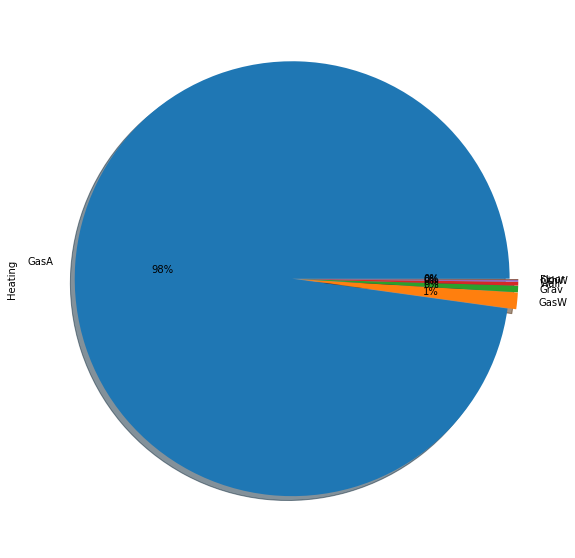

2023-04-18 06:23:11,754 - _utils.logging_utils - INFO - ['HeatingQC']
2023-04-18 06:23:11,822 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:11,824 - _utils.logging_utils - INFO - 
Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64


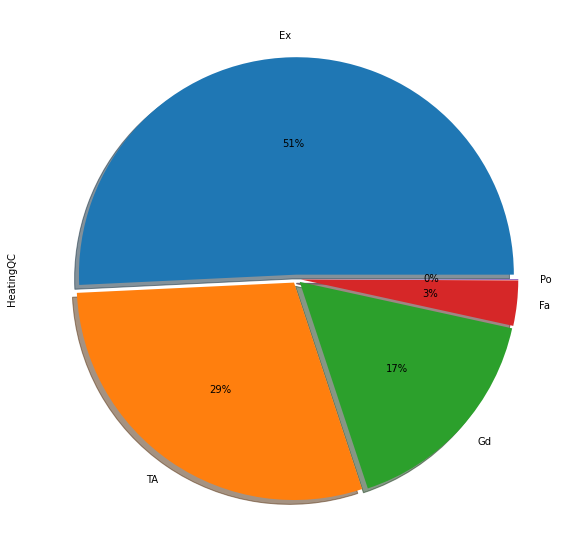

2023-04-18 06:23:11,949 - _utils.logging_utils - INFO - ['CentralAir']
2023-04-18 06:23:12,019 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:12,021 - _utils.logging_utils - INFO - 
Y    1365
N      95
Name: CentralAir, dtype: int64


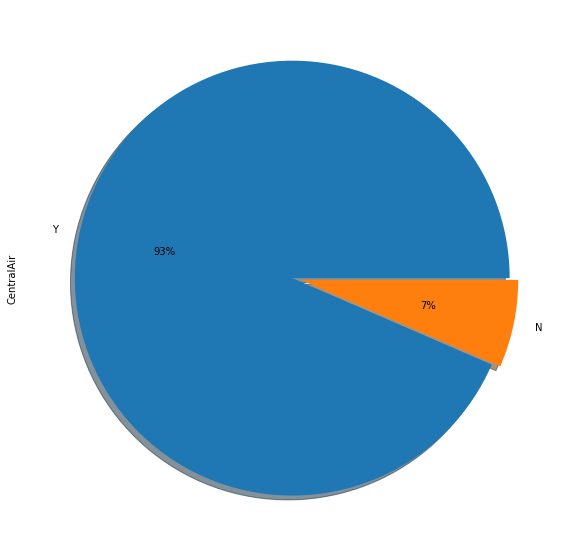

2023-04-18 06:23:12,122 - _utils.logging_utils - INFO - ['Electrical']
2023-04-18 06:23:12,201 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:12,203 - _utils.logging_utils - INFO - 
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NA          1
Name: Electrical, dtype: int64


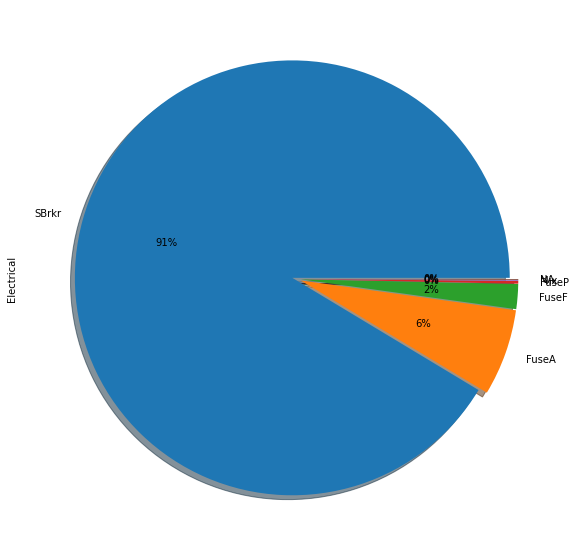

2023-04-18 06:23:12,352 - _utils.logging_utils - INFO - ['KitchenQual']
2023-04-18 06:23:12,409 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:12,412 - _utils.logging_utils - INFO - 
TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64


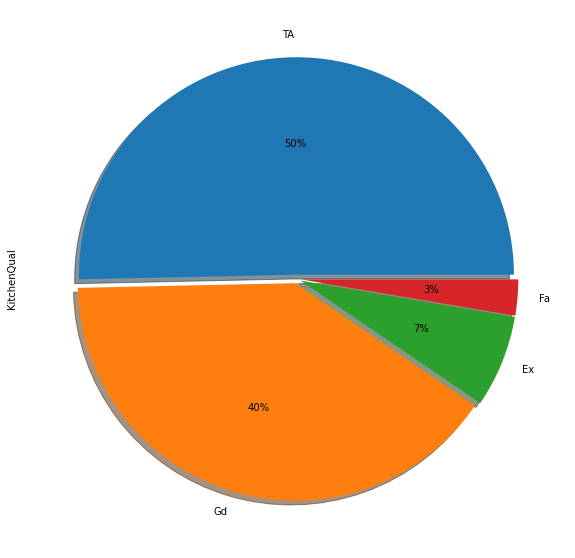

2023-04-18 06:23:12,520 - _utils.logging_utils - INFO - ['Functional']
2023-04-18 06:23:12,584 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:12,587 - _utils.logging_utils - INFO - 
Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64


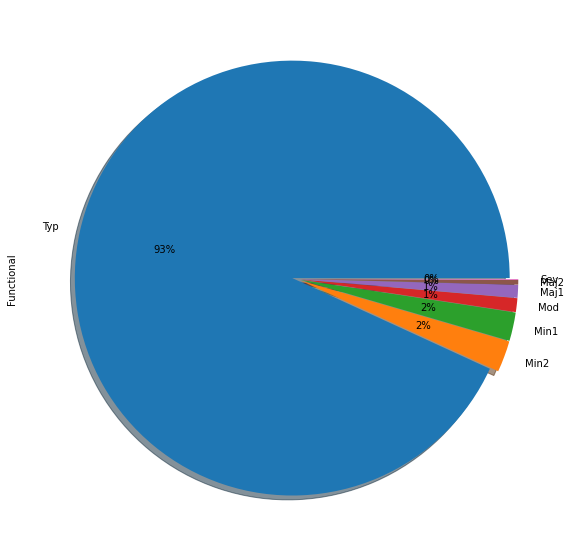

2023-04-18 06:23:12,746 - _utils.logging_utils - INFO - ['FireplaceQu']
2023-04-18 06:23:12,815 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:12,816 - _utils.logging_utils - INFO - 
NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64


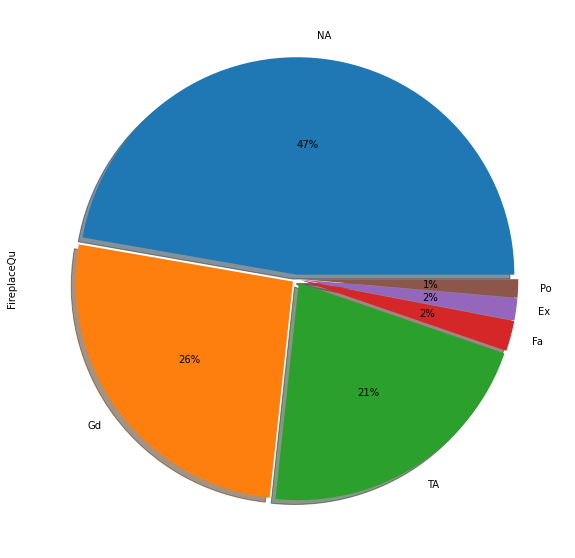

2023-04-18 06:23:12,937 - _utils.logging_utils - INFO - ['GarageType']
2023-04-18 06:23:13,017 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:13,018 - _utils.logging_utils - INFO - 
Attchd     870
Detchd     387
BuiltIn     88
NA          81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64


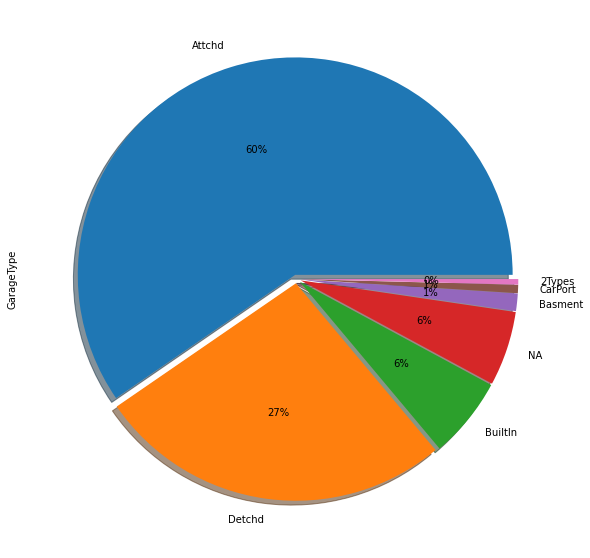

2023-04-18 06:23:13,159 - _utils.logging_utils - INFO - ['GarageFinish']
2023-04-18 06:23:13,219 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:13,221 - _utils.logging_utils - INFO - 
Unf    605
RFn    422
Fin    352
NA      81
Name: GarageFinish, dtype: int64


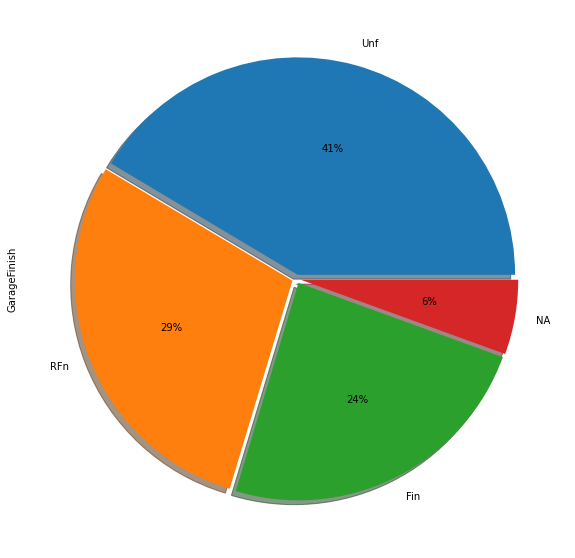

2023-04-18 06:23:13,329 - _utils.logging_utils - INFO - ['GarageQual']
2023-04-18 06:23:13,408 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:13,409 - _utils.logging_utils - INFO - 
TA    1311
NA      81
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64


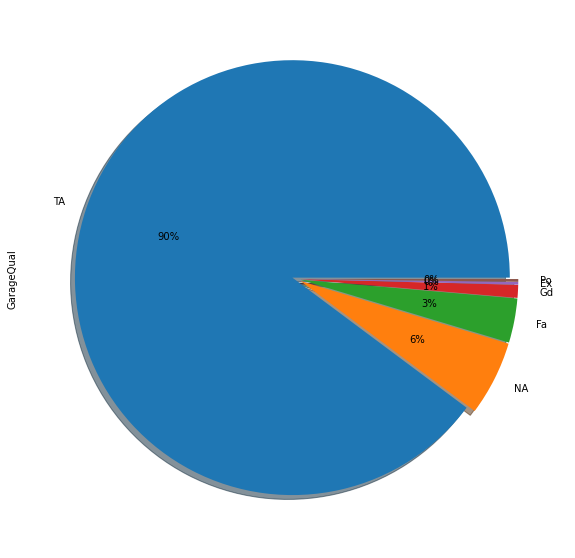

2023-04-18 06:23:13,547 - _utils.logging_utils - INFO - ['GarageCond']
2023-04-18 06:23:13,626 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:13,627 - _utils.logging_utils - INFO - 
TA    1326
NA      81
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64


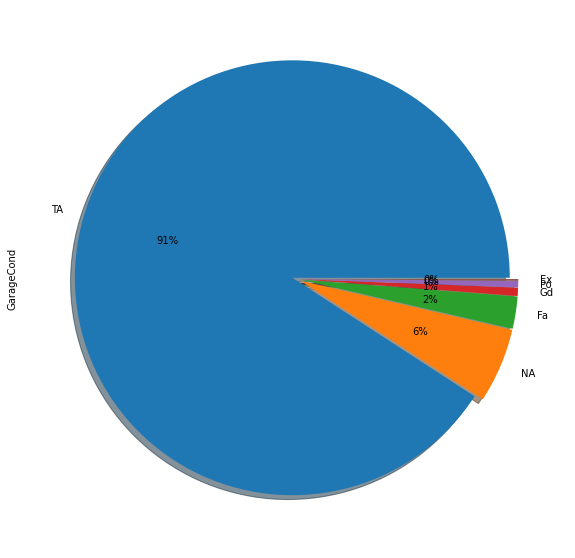

2023-04-18 06:23:13,768 - _utils.logging_utils - INFO - ['PavedDrive']
2023-04-18 06:23:13,845 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:13,846 - _utils.logging_utils - INFO - 
Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64


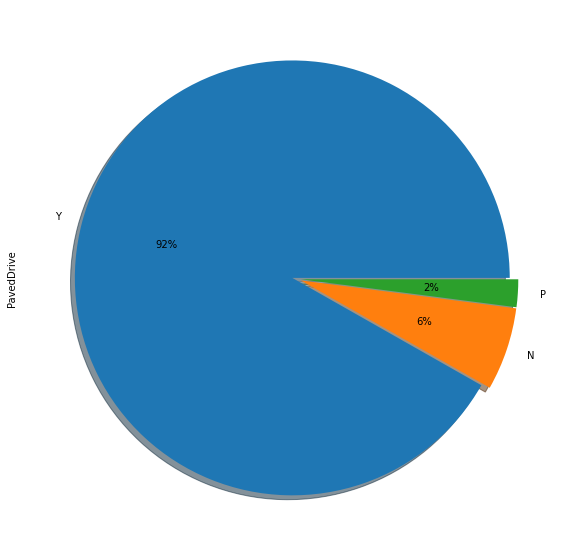

2023-04-18 06:23:13,959 - _utils.logging_utils - INFO - ['PoolQC']
2023-04-18 06:23:14,022 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:14,025 - _utils.logging_utils - INFO - 
NA    1453
Gd       3
Ex       2
Fa       2
Name: PoolQC, dtype: int64


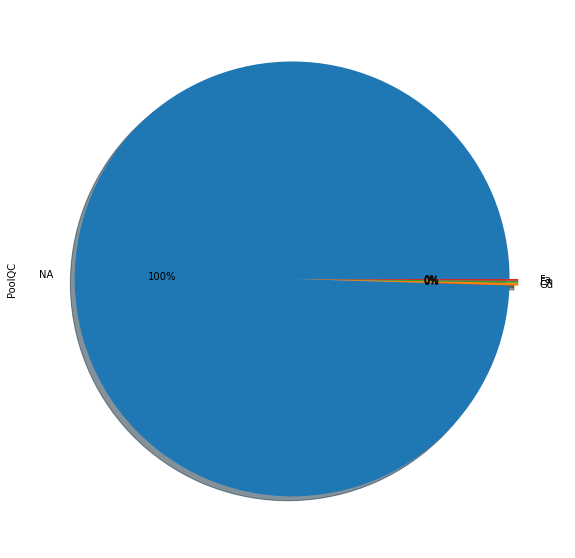

2023-04-18 06:23:14,163 - _utils.logging_utils - INFO - ['Fence']
2023-04-18 06:23:14,218 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:14,219 - _utils.logging_utils - INFO - 
NA       1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64


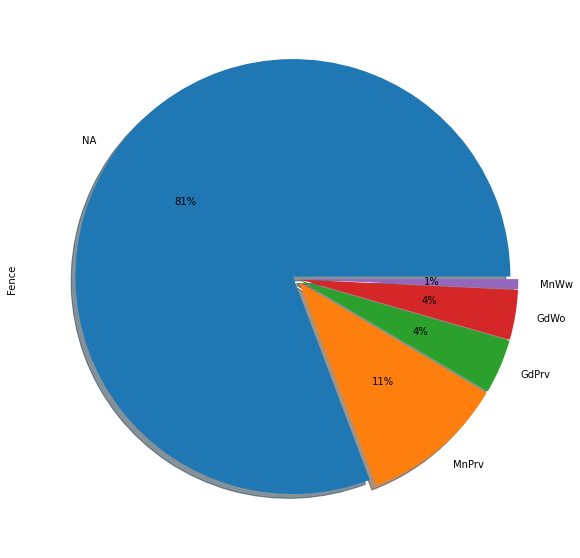

2023-04-18 06:23:14,353 - _utils.logging_utils - INFO - ['MiscFeature']
2023-04-18 06:23:14,475 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:14,476 - _utils.logging_utils - INFO - 
NA      1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64


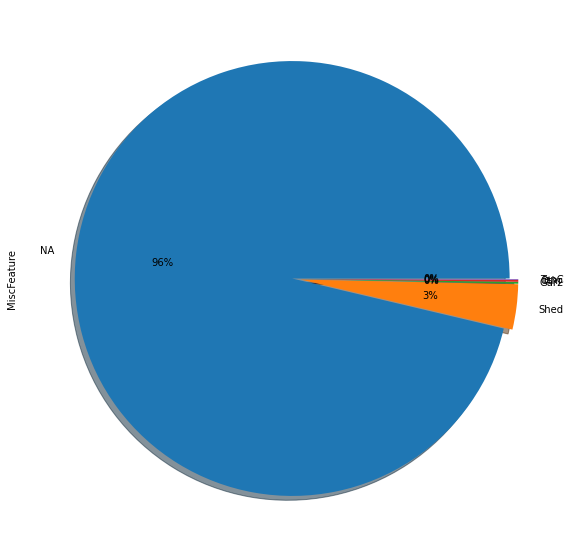

2023-04-18 06:23:14,645 - _utils.logging_utils - INFO - ['SaleType']
2023-04-18 06:23:14,704 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:14,706 - _utils.logging_utils - INFO - 
WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64


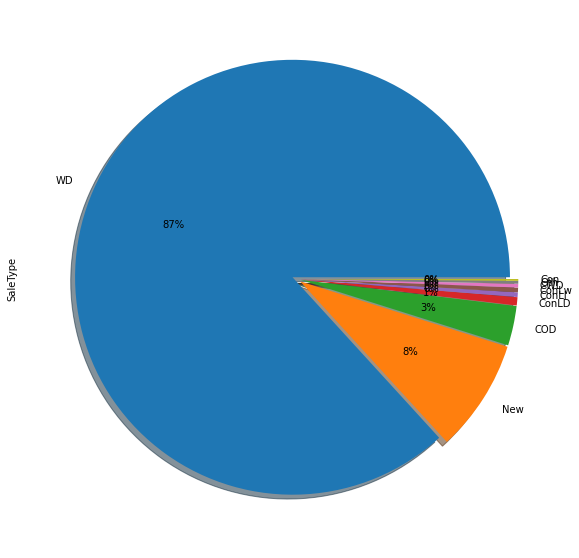

2023-04-18 06:23:14,886 - _utils.logging_utils - INFO - ['SaleCondition']
2023-04-18 06:23:14,965 - _utils.logging_utils - DEBUG - describe_categoric executing...
2023-04-18 06:23:14,966 - _utils.logging_utils - INFO - 
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64


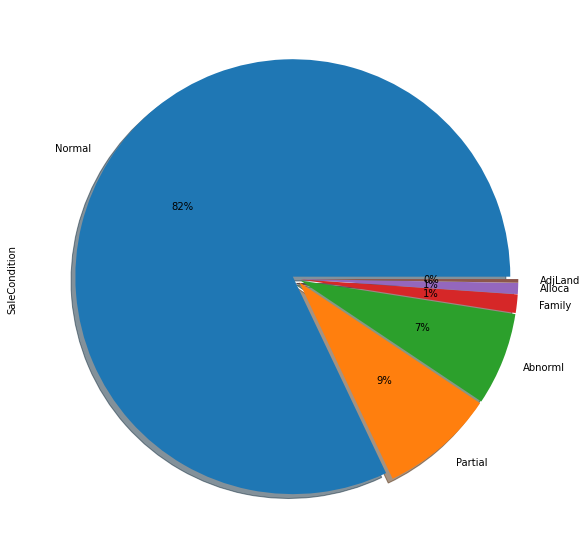

In [22]:
describe_categoric_columns(df.select(cat_cols))

Result is the categoric columns have got too rare features. Should to analyze rare features one by one. After analysis, merge rare features to each other.
#### Describing Columns for Target

In [23]:
describe_columns_to_target(df, cat_cols, 'SalePrice')

2023-04-18 06:25:21,095 - _utils.logging_utils - DEBUG - describe_columns_to_target executing...
+--------+------------------+------+------------------+
|MSZoning|Mean              |Median|Std               |
+--------+------------------+------+------------------+
|C (all) |74528.0           |68400 |33791.092031283435|
|RM      |126316.83027522935|120500|48521.68983254896 |
|RH      |131558.375        |133000|35714.11843491777 |
|RL      |191004.99478714162|174000|80766.3413193025  |
|FV      |214014.06153846154|205950|52369.66206744754 |
+--------+------------------+------+------------------+

+------+------------------+------+-----------------+
|Street|Mean              |Median|Std              |
+------+------------------+------+-----------------+
|Grvl  |130190.5          |110000|65446.25399134774|
|Pave  |181130.53851444292|163000|79446.59731743201|
+------+------------------+------+-----------------+

+-----+------------------+------+-----------------+
|Alley|Mean              |M

Can analyze categorical columns for target columns.

### Checking Missing and Outliers

#### Missing Values

In [26]:
check_missing_values(df)

2023-04-18 06:26:55,282 - _utils.logging_utils - DEBUG - check_missing_values executing...
2023-04-18 06:26:55,983 - _utils.logging_utils - INFO - LotFrontage has 259 -  17.74 % null count.
2023-04-18 06:26:56,380 - _utils.logging_utils - INFO - Alley has 1369 -  93.77 % null count.
2023-04-18 06:26:58,619 - _utils.logging_utils - INFO - MasVnrType has 872 -  59.73 % null count.
2023-04-18 06:26:58,735 - _utils.logging_utils - INFO - MasVnrArea has 8 -  0.55 % null count.
2023-04-18 06:26:59,203 - _utils.logging_utils - INFO - BsmtQual has 37 -  2.53 % null count.
2023-04-18 06:26:59,325 - _utils.logging_utils - INFO - BsmtCond has 37 -  2.53 % null count.
2023-04-18 06:26:59,444 - _utils.logging_utils - INFO - BsmtExposure has 38 -  2.60 % null count.
2023-04-18 06:26:59,588 - _utils.logging_utils - INFO - BsmtFinType1 has 37 -  2.53 % null count.
2023-04-18 06:26:59,835 - _utils.logging_utils - INFO - BsmtFinType2 has 38 -  2.60 % null count.
2023-04-18 06:27:00,630 - _utils.logging_

Some columns are nearly empty therefore it can be drop from dataframe.

In [27]:
drop_cols = ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

df = df.drop(*drop_cols)

In [29]:
num_cols = [col for col in num_cols if col not in drop_cols]
cat_cols = [col for col in cat_cols if col not in cat_cols]

In [28]:
check_missing_values(df)

2023-04-18 06:28:51,974 - _utils.logging_utils - DEBUG - check_missing_values executing...
2023-04-18 06:28:52,427 - _utils.logging_utils - INFO - LotFrontage has 259 -  17.74 % null count.
2023-04-18 06:28:54,747 - _utils.logging_utils - INFO - MasVnrArea has 8 -  0.55 % null count.
2023-04-18 06:28:55,183 - _utils.logging_utils - INFO - BsmtQual has 37 -  2.53 % null count.
2023-04-18 06:28:55,290 - _utils.logging_utils - INFO - BsmtCond has 37 -  2.53 % null count.
2023-04-18 06:28:55,409 - _utils.logging_utils - INFO - BsmtExposure has 38 -  2.60 % null count.
2023-04-18 06:28:55,524 - _utils.logging_utils - INFO - BsmtFinType1 has 37 -  2.53 % null count.
2023-04-18 06:28:55,754 - _utils.logging_utils - INFO - BsmtFinType2 has 38 -  2.60 % null count.
2023-04-18 06:28:56,473 - _utils.logging_utils - INFO - Electrical has 1 -  0.07 % null count.
2023-04-18 06:28:58,030 - _utils.logging_utils - INFO - GarageType has 81 -  5.55 % null count.
2023-04-18 06:28:58,151 - _utils.logging_u

#### Outliers

In [30]:
check_outlier_values(df, num_cols)

2023-04-18 06:29:57,977 - _utils.logging_utils - DEBUG - check_outlier_values executing...
2023-04-18 06:29:58,032 - _utils.logging_utils - INFO - TotalBsmtSF has 1 - %  0.07 outliers count.
2023-04-18 06:29:58,267 - _utils.logging_utils - INFO - PoolArea has 7 - %  0.48 outliers count.
2023-04-18 06:29:58,331 - _utils.logging_utils - INFO - LotArea has 4 - %  0.27 outliers count.
2023-04-18 06:29:58,375 - _utils.logging_utils - INFO - MiscVal has 8 - %  0.55 outliers count.
2023-04-18 06:29:59,250 - _utils.logging_utils - INFO - BsmtFinSF1 has 1 - %  0.07 outliers count.
2023-04-18 06:29:59,392 - _utils.logging_utils - INFO - 3SsnPorch has 1 - %  0.07 outliers count.


{0: {'column_name': 'TotalBsmtSF',
  'outlier_count': 1,
  'up_limit': 5387.625,
  'low_limit': -3232.5750000000003,
  'ratio': 0.0684931506849315},
 4: {'column_name': 'PoolArea',
  'outlier_count': 7,
  'up_limit': 0.0,
  'low_limit': 0.0,
  'ratio': 0.4794520547945206},
 5: {'column_name': 'LotArea',
  'outlier_count': 4,
  'up_limit': 91399.10000000053,
  'low_limit': -52151.46000000031,
  'ratio': 0.273972602739726},
 6: {'column_name': 'MiscVal',
  'outlier_count': 8,
  'up_limit': 1750.0,
  'low_limit': -1050.0,
  'ratio': 0.547945205479452},
 22: {'column_name': 'BsmtFinSF1',
  'outlier_count': 1,
  'up_limit': 3931.0250000000005,
  'low_limit': -2358.6150000000002,
  'ratio': 0.0684931506849315},
 25: {'column_name': '3SsnPorch',
  'outlier_count': 1,
  'up_limit': 420.0,
  'low_limit': -252.0,
  'ratio': 0.0684931506849315}}

## Final
Dataset is the so complex. It have to handle outliers, missing, values and rare features. **EDA** is already finished. Final operation is the dropping the *id column*. After these save the final dataframe as parquet.

In [31]:
df = df.drop("Id")

In [32]:
path = "file:///Users/talha/OneDrive/Masaüstü/Talha Nebi Kumru/Data Science/Miuul/Machine Learning/House_Price_Prediction/datasets/eda/house.parquet"
df.write.parquet(path)

In [33]:
spark.stop()